#**Trabalho Final de Cálculo Numérico - SME0104 - 2020/1**
**Professora:** Cynthia de Oliveira Lage Ferreira

**Monitora PAE:** Camila Faria Afonso Lages

**Dupla:**

*   Marcelo Isaias de Moraes Junior - **Número USP**: 10550218
*   Guilherme Targon Marques Barcellos - **Número USP**: 10724181

O trabalho consiste em uma revisão teórica sobre **4 tópicos** dentre os abrangidos pela disciplina de cálculo numérico, explicando e implementando seus métodos utilizando a linguagem *Python* com as bibliotecas de apoio *Numpy*, *Scipy* e *Matplotlib*, e por fim, suas aplicações. Foram escolhidos os seguintes tópicos:

1.   **Solução de Sistemas Lineares**
2.   **Problemas de Autovalor**
3.   **Interpolação Polinomial**
4.   **Método dos Mínimos Quadrados**




#**[TÓPICO 1]: Solução de Sistemas Lineares**
---
## Métodos Diretos
Os métodos diretos consistem em algoritmos que nos dão uma resposta exata do sistema linear $Ax = b$ (fora o erro de aproximação decimal ao trabalharmos com variáveis do tipo float), isto é, consistem em um número finito de operações a fim de dar uma resposta exata para aquele sistema. Entretanto são conhecidos por serem métodos muito custosos dado que para cada ordem de matriz terá um número finito de operações para cada, desta forma, ao desejarmos calcular uma matriz muito grande não teríamos tempo de vida para ver a própria solução do sistema.

Nos métodos diretos, veremos que as soluções consistem em fatorar a matriz $A$ em duas matrizes triangulares: a superior e a inferior.




Antes de começarmos com os metodos diretos, deve-se explicar sobre a sequência de substituições que nos levam aos resultados no métodos LU e Choelesky, isto é, como que é feita a resolução de sistemas triangulares. São feitas duas substituições: a **progressiva** e a **regressiva**.

Dado o sistema linear $Ax = b$, em que $A = L.U$ (usado na decomposição LU), $L =$ matriz triangular inferior e $U =$ matriz triangular superior. Então:
*   A **progressiva** resolve um sistema triangular inferior. Para tal, tomamos que $y = Ux$, portanto, a progressiva irá resolver o sistema $Ly = b$. Obtemos como resposta o vetor solução $y$
*   A **regressiva** resolve um sistema triangular superior, portanto, irá resolver o sistema $Ux = y$, utilizando o vetor solução $y$ obtido na substituição progressiva. Por fim obtemos o vetor solução $x$, que consiste no vetor solução do sistema ao qual queríamos resolver ($Ax = b$)



In [32]:
import numpy as np
import sympy
import scipy as sp
import scipy.linalg

def forwardSubst(L,b):  #Substituicao progressiva
  n = np.shape(L)[0] #obtem a ordem da matriz
  y = np.zeros(n) #variavel da subtituicao progressiva y = Ux
  
  for i in range(n):
    summation = 0  
    for j in range(i):
      summation += L[i,j] * y[j]
    y[i] = (b[i] - summation)/L[i,i]

  return y

def backwardSubst(U,y): #Substituicao regressiva
  n = np.shape(U)[0] #obtem a ordem da matriz
  x = np.zeros(n)    #vetor das variaveis do sistema linear, armazena o resultado final do sistema Ax = b

  for i in range(n-1,-1,-1):
    summation = 0
    for j in range(i+1,n):
      summation += U[i,j] * x[j]
    x[i] = (y[i] - summation)/U[i,i]

  return x


###Método: Decomposição LU

Seu nome já diz muito sobre ela mesmo, isto é, seu objetivo é achar duas matrizes triangulares $L$ (inferior) e $U$ (superior), tais que $A = L.U$, após isto, aplicar substituição progressiva e regressiva (como fora exemplificado no texto acima) afim de resolver o sistema linear $Ax = b$ ($Ax = LUx = b$). 
Segundo o teorema de existência e unicidade da decomposição LU, se o determinante de $A_{k}$ menores principais)**for diferente de 0** para $k = 1, ..., n$ (ordem da matriz $A$), então existem uma única matriz $L$ e uma única matriz $U$.
As menores principais são sub-matrizes de ordem k dentro da matriz A, o que o teorema nos diz é que se todas as menores principais tiverem determinante diferente de 0, então a decomposição existe e é única.

**Um fato interessante sobre a decomposição LU:** para calcularmos o determinante da matriz $A$, dada que $A = LU$, é muito simples, visto que
$det(A) = det(L).det(U)$, como o cálculo do determinante das matrizes triangulares consiste apenas no produtório da diagonal principal, então $det(L) = 1$. Logo temos que $det(A) = det(U)$, em que $det(U) = \prod_{i=1}^{n}u_{ii}$ é calculado apenas pelo produtório de seus elementos da diagonal principal.

Para este trabalho, foi escolhido o algoritmo **Doolittle**. O algoritmo utiliza a ordem de cálculo de $L$,$U$ por meio da sequência de operações: primeira linha de $U$, primeira coluna de $L$, segunda linha de $U$, segunda coluna de $L$, .... , $n$ linha de $U$, $n$ coluna de $L$. E então temos:

* Elementos da matriz U: $u_{ij} = a_{ij} - \sum_{k=1}^{i-1}l_{ik}u_{kj}$, para $j \geq i$

* Elementos da matriz L: $l_{ij} = \frac{a_{ij} - \sum_{k=1}^{j-1}l_{ik}u_{kj}}{u_{jj}}$, para $i > j$

In [33]:
def calc_determinant(U): #Dada uma matriz A que foi decomposta em L, U, calcula o determinante da matriz A
  #det(A) = det(L).det(U)
  #det(A) =      1.det(U) = produtorio de todos os elementos da diagonal principal de U
  n = np.shape(U)[0]
  
  det = 1
  for i in range(n): #Percorre todos os elementos da diagonal principal
    det *= U[i,i]
  
  return det

def LU_Decomposition(A):
  if np.shape(A)[0] != np.shape(A)[1]:
    raise Exception('A nao eh uma matriz quadrada!')

  n = np.shape(A)[0]    #obtem a ordem da matriz A
  L = np.eye(n)         #inicializa a matriz triangular inferior como uma matriz identidade
  U = np.zeros((n,n))   #inicializa a matriz triangular superior
  
  for i in range(n):    #percorre de 0 a n-1
    for j in range(i,n):  #percorre a linha i de U a partir do elemento da diagonal principal
      U[i,j] =  A[i,j]  - sum(L[i,k] * U[k,j] for k in range(i)) #calculo da i-esima linha de U
    for j in range(i+1,n): #percorre a coluna i de L a partir do elemento abaixo da diagonal principal. Calculo da i-esima coluna de L
      L[j,i] = (A[j,i]  - sum(L[j,k]*  U[k,i] for k in range(i)))/U[i,i] #Perceba o pivot, e se este for igual ou muito proximo a zero: Erro!!!
  return L,U

def LU_Solver(A,b):     #Resolve um sistema linear por meio da decomposicao LU
  L,U = LU_Decomposition(A)  #Realiza a decomposicao LU
  y = forwardSubst(L,b)    #Variavel da subsituicao progressiva y = Ux entao Ax = Ly = b. Resolve o sistema Ly = b
  x = backwardSubst(U,y)   #Variavel da substiuicao regressiva, isto e, obter os valores do vetor x. Resolve o sistema Ux = y.
  return x

def LU_Solver2(L,U,b): #Resolve um sistema linear em que a decomposicao LU foi realizada previamente
  y = forwardSubst(L,b)
  x = backwardSubst(U,y)
  return x


A_ex1 = np.array([[2.0, -3.0, -1.0],
                  [3.0,  2.0, -5.0],
                  [2.0,  4.0, -1.0]])

b_ex1 = np.array([3.0,-9.0,-5.0])

A_ex2 = np.array([[2, 0, -1, 0],
                  [0, 1,  2, 0],
                  [-1, 2, 0, 1],
                  [0, 0, 1, -2]])


#Solucao do sistema usando apenas nossas funcoes
L,U = LU_Decomposition(A_ex1)
x = LU_Solver(A_ex1,b_ex1)
print('Solucao do sistema: ')
print(x)
print('Determinante de A: %f' %(calc_determinant(U)))  #determinante calculado apenas por U, pois det(A) = det(U)
print('')

A_ex1_c = np.copy(A_ex1)
b_ex1_c = np.copy(b_ex1)

#Solucao do sistema da biblioteca do python
x_real = np.linalg.solve(A_ex1_c,b_ex1_c)
print('Solucao do sistema do python: ')
print(x_real)
print('Determinante de A do python: %f' %(np.linalg.det(A_ex1_c)))  #determinante calculado atraves de A


Solucao do sistema: 
[ 0.65306122 -1.14285714  1.73469388]
Determinante de A: 49.000000

Solucao do sistema do python: 
[ 0.65306122 -1.14285714  1.73469388]
Determinante de A do python: 49.000000


### **Extra: Cálculo de matriz inversa**
A matriz inversa de uma matriz quadrada A não-singular pode ser calculada por meio da resolução de $n$ sistemas lineares $Av_{i} = e_{i}$ em que $v_{i}$ é o i-ésimo vetor da matriz inversa e $e_{i}$ o i-ésimo vetor da matriz identidade. Logo o sistema linear é calculado para cada vetor da matriz inversa, portanto $n$ (ordem da matriz) vezes. 

In [34]:
def inverseMatrix(A):
  n = np.shape(A)[0]          #obtem a ordem da matriz a ter sua inversa calculada
  invA = np.zeros((n,n))      
  matIden = np.identity(n)    #matriz identidade
  L,U = LU_Decomposition(A)   #decompoe a matriz A em L,U
  for i in range(0,n):        #Realiza o calculo de cada vetor da matriz inversa por meio da resolucao do sistema linear Avi = ei explicado anteriormente
    invA[:, i] = LU_Solver2(L,U,matIden[:,i])
  
  return invA



Matriz = np.array([[ 3.0, 5.0,1.0],
                   [ 2.0,-1.0,0.0],
                   [-1.0, 3.0,1.0]])

Matriz_inversa = inverseMatrix(Matriz)
Matriz_inversa_python = np.linalg.inv(Matriz)

print('Matriz inversa: ')
print(Matriz_inversa)
print('Produto da Matriz e sua Matriz_inversa') 
print(Matriz.dot(Matriz_inversa)) #Nos da uma matriz identidade (fora o erro de aproximacao de float)
print('')
print('Matriz inversa do Python: ')
print(Matriz_inversa_python)

Matriz inversa: 
[[ 0.125  0.25  -0.125]
 [ 0.25  -0.5   -0.25 ]
 [-0.625  1.75   1.625]]
Produto da Matriz e sua Matriz_inversa
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.55111512e-17  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.22044605e-16  1.00000000e+00]]

Matriz inversa do Python: 
[[ 0.125  0.25  -0.125]
 [ 0.25  -0.5   -0.25 ]
 [-0.625  1.75   1.625]]


###Método: Decomposição de Cholesky

Dada uma matriz A simétrica ($A = A^t$) positiva definida **(SPD)**, para ser SPD, a matriz A deve ter todos os determinantes de seus menores principais positivos e todos seus **autovalores positivos** também. 

Neste método, queremos uma matriz triangular inferior tal que 
$A = LL^t$. Após isto, aplicamos as substituições progressiva e regressiva do mesmo modo que na Decomposição LU, neste caso a matriz triangular superior $U$ será a transposta de $L$ encontrada.

O algoritmo apenas se baseia no calculo de $L$, então este método possui uma grande vantagem em relação à decomposição LU, uma vez que por utilizar uma matriz $L$ e sua transposta apenas, podemos utilizar apenas uma matriz para isso e então, gastando metade da memória gasta na decomposição LU com duas matrizes. Os elementos da diagonal principal são calculados de um modo diferente do que os elementos fora diagonal principal, isto é, abaixo dela. Para os cálculos utilizamos: 

*  Para elementos da diagonal: $l_{ii} = \sqrt{a_{ii} - \sum_{j = 1}^{i-1}l_{ij}^2}$

*  Para elementos abaixo da diagonal ($i > j$): 
$l_{ij} = \frac{a_{ij} - \sum_{k=1}^{j-1}l_{ik}l_{jk}}{l_{jj}}$

* Além disso, podemos ver que os dois somátorios são idênticos para o cálculo do elemento da diagonal e abaixo, portanto: $summation = \sum_{k=1}^{j-1}l_{ik}l_{jk}$ dado $l_{ij}$.

**Um fato interessante sobre a Decomposição de Cholesky:** caso a matriz A não seja SPD, durante o calculo dos elementos da diagonal principal, haverá um problema: cálculo de raiz quadrada de números negativos! 

In [35]:
def choleskyDecomposition(A):
  if np.shape(A)[0] != np.shape(A)[1]:
    raise Exception('A nao eh uma matriz quadrada!')

  n = np.shape(A)[0]  #obtem a ordem da matriz A
  L = np.zeros((n,n)) #inicializa a matriz L da decomposicao de cholesky

  for i in range(n): 
    for j in range(i+1): #com estes 2 for's percorremos por todos elementos da diagonal principal e abaixo dela
      summation = sum(L[i,k]*L[j,k] for k in range(j)) #armazena o resultado do somatorio que sera utilizado

      #Se for um elemento da diagonal principal
      if i == j:
        temp = A[i,i] - summation
        if temp < 0:
          raise Exception('A matriz nao eh SPD!')
        L[i,j] = np.sqrt(temp)
      else: #Se for um elemento abaixo da diagonal principal
        L[i,j] = 1.0 / L[j,j] * (A[i][j] - summation) 

  return L


def Cholesky_Solver(A,b):
  L = choleskyDecomposition(A) #Realiza a decomposicao de cholesky
  y = forwardSubst(L,b)    #variavel da substituicao progressiva y = Ltransposta.x entao Ax = Ly = b
  L = np.transpose(L)     #Calcula a transposta da matriz L obtida pela decomposicao de cholesky
  x = backwardSubst(L,y)  #variavel da substituicao regressiva, isto e, obter os valores do vetor x. A matriz U, sera a transposta de L, devido a decomposicao de Cholesky. Resolve Ltransposta.x = y
  return x





def build_matrix(n):      #constroi o sistema linear do trabalho 1 disponibilizado pela disciplina
  A = np.zeros((n,n))
  b = np.zeros(n)
  b.fill(1/n)

  diag1 = np.zeros(n)
  diag1.fill(6.0)
  diag1[0] = 9.0
  diag1[n-2] = 5.0
  diag1[n-1] = 1.0

  diag2 = np.ones(n-2)

  diag3 = np.zeros(n-1)
  diag3.fill(-4.0)
  diag3[n-2] = -2.0

  A = np.diag(diag3,1) + np.diag(diag3,-1) + np.diag(diag1) + np.diag(diag2,2) + np.diag(diag2,-2)

  print('Matriz A montada para o exercicio: ')
  print(A)
  print('Vetor b montado para o exercicio: ')
  print(b)
  print('')

  return A,b



A_chol,b_chol = build_matrix(10)

print('Cholesky implementado: ')
print('Matriz L obtida:')
print(choleskyDecomposition(A_chol))
print('\nSolução')
print(Cholesky_Solver(A_chol, b_chol))

print('')

print('Biblioteca do Python: ')
print('Matriz L obtida: ')
print(scipy.linalg.cholesky(A_chol, lower=True))
print('\nSolução: ')
print(np.linalg.solve(A_chol, b_chol))

Matriz A montada para o exercicio: 
[[ 9. -4.  1.  0.  0.  0.  0.  0.  0.  0.]
 [-4.  6. -4.  1.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  6. -4.  1.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  6. -4.  1.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  6. -4.  1.  0.  0.  0.]
 [ 0.  0.  0.  1. -4.  6. -4.  1.  0.  0.]
 [ 0.  0.  0.  0.  1. -4.  6. -4.  1.  0.]
 [ 0.  0.  0.  0.  0.  1. -4.  6. -4.  1.]
 [ 0.  0.  0.  0.  0.  0.  1. -4.  5. -2.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]]
Vetor b montado para o exercicio: 
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

Cholesky implementado: 
Matriz L obtida:
[[ 3.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [-1.33333333  2.05480467  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.33333333 -1.73036183  1.70139262  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.48666426 -1.85606467  1.52255766  0.          

###Eliminação de Gauss
Este método tem como intuito transformar uma matriz quadrada A em uma matriz triangular superior, após isto, aplicar a substituição regressiva para obter a solução do sistema linear $Ax = b$. Para transformar o sistema em um sistema triangular superior, a eliminação de Gauss utiliza de uma matriz expandida $[A|b]$ e operações elementares sobre esta. As operações elementares **não** alteram a solução do mesmo, nem o determinante, são usadas pela eliminação de Gauss:

*   $L_{i} \leftrightarrow L_{j}$: **Troca entre duas linhas**, usada apenas para eliminação de Gauss com pivoteamento parcial;
*   $L_{i} \leftarrow L_{i} + kL_{j}$: **Multiplicação de uma linha por uma constante diferente de zero** e **soma de duas linhas**. Usada para eliminar todos os elementos abaixo do pivô.

A eliminação de Gauss possui dois tipos, com pivoteamento fixo e com o parcial. Para o pivoteamento fixo, não há troca entre as linhas, entretanto é muito suscetível a erro, uma vez que caso o pivô seja muito proximo a zero, teremos um erro da divisão por zero na hora de calcularmos o coeficiente $m = \frac{A_{ij}}{A_{ii}}$, em que $A_{ii}$ é chamado de **Pivô**, para a fase de eliminação. Para impedir que este erro aconteça, é necessário que procuremos na coluna o maior elemento  em módulo para ser o pivô, ao achá-lo é feita a troca entre as duas linhas. 



In [36]:
def gauss_elimination(A_old,b_old):
  A = np.copy(A_old)
  b = np.copy(b_old)
  if np.shape(A)[0] != np.shape(A)[1]:
    raise Exception('A nao eh uma matriz quadrada!')

  n = np.shape(A)[0]

  for i in range(n-1):    #ate a penultima linha
    for j in range(i+1,n):    #da linhha pivot ate a ultima linha
      m = -A[j,i]/A[i,i]  #calculo do coeficiente que sera aplicado a linha toda, perceba o que ocorre se o pivot A[i,i] for muito proximo a 0: erro divisão por 0
      A[j,i:n] = A[j,i:n] + m*A[i,i:n] #a operacao para o elemento zerar o elemento abaixo do pivot eh aplicada na linha inteira
      b[j] = b[j] + m*b[i] #inclusive no vetor b, pois eliminacao de gauss trabalha com a matriz expandida [A|b]
  
  return backwardSubst(A,b) #substituicao regressiva (resolucao do sistema triangular superior formado)


def swapRows(A,b,i):  #dada a linha atual da eliminacao de gauss, procura o maior pivot entre as linhas abaixo e realiza a troca entre as linhas 
  n = np.shape(A)[0]
  greatest_i = i       #indice da linha onde se encontra o maior indice
  
  for j in range(i+1,n):      #procura pelo indice de linha onde o maior elemento em modulo da coluna abaixo do pivot esta
    if  abs(A[j,i]) > abs(A[greatest_i,greatest_i]):
      greatest_i = j

  for j in range(i,n): #troca entre a linha do maior e o pivot, percorrendo cada coluna a partir do elemento da diagonal
    temp = A[i,j]
    A[i,j] = A[greatest_i,j]
    A[greatest_i,j] = temp
  
  temp = b[i]           #troca inclusive no vetor b por ser uma matriz expandida [A|b]
  b[i] = b[greatest_i]
  b[greatest_i] = temp

  
def gauss_elimination_partial(A_old,b_old):
  A = np.copy(A_old)
  b = np.copy(b_old)
  if np.shape(A)[0] != np.shape(A)[1]:
    raise Exception('A nao eh uma matriz quadrada!')

  n = np.shape(A)[0]

  for i in range(n-1):    #ate a penultima linha
    swapRows(A,b,i)
    for j in range(i+1,n):    #da linhha pivot ate a ultima linha
      m = -A[j,i]/A[i,i]  #calculo do coeficiente que sera aplicado a linha toda, perceba o que ocorre se o pivot A[i,i] for muito proximo a 0: erro divisão por 0
      A[j,i:n] = A[j,i:n] + m*A[i,i:n] #a operacao para o elemento zerar o elemento abaixo do pivot eh aplicada na linha inteira
      b[j] = b[j] + m*b[i] #inclusive no vetor b, pois eliminacao de gauss trabalha com a matriz expandida [A|b]
    
  return backwardSubst(A,b) #substituicao regressiva (resolucao do sistema triangular superior formado)

A_ex3 = np.array([[2.0,1.0, 2.0],
                  [4.0,3.0, 3.0],
                  [6.0,5.0,-1.0]])

b_ex3 = np.array([-1.0,0.0,6.0])

A_ex4 = np.array([[2.0, -3.0, -1.0],
                  [3.0,  2.0, -5.0],
                  [2.0,  4.0, -1.0]])

b_ex4 = np.array([3.0,-9.0,-5.0])

A_ex5 = np.array([[0, 1.0, 2.0],
                  [1.0, -1.0, 3.0],
                  [-2.0, 3.0, 1.0]])

b_ex5 = np.array([8.0, 8.0, 7.0])




print('1 - Gauss normal: ')
print(gauss_elimination(A_ex3, b_ex3))
print('')
print('1.1 - Gauss parcial para o mesmo exemplo usado acima: ')
print(gauss_elimination_partial(A_ex3,b_ex3))
print('')
print('2 - Neste exemplo, o gauss normal nao iria funcionar, pois o pivot é 0 e nos daria divisão por zero!!')
print('Então usamos Gauss parcial: ')
print(gauss_elimination_partial(A_ex5,b_ex5))
print('')
print('3 - Gauss parcial: ')
print(gauss_elimination_partial(A_ex1,b_ex1))
print('\n')

print('Respostas do python respectivamente para os sistemas acima: ')
A_ex3_c = np.copy(A_ex3)
b_ex3_c = np.copy(b_ex3)
print('Resposta do python para 1:')
print(np.linalg.solve(A_ex3_c,b_ex3_c))
print('')

A_ex5_c = np.copy(A_ex5)
b_ex5_c = np.copy(b_ex5)
print('Resposta do python para 2:')
print(np.linalg.solve(A_ex5_c, b_ex5_c))
print('')

A_ex1_c = np.copy(A_ex1)
b_ex1_c = np.copy(b_ex1)
print('Resposta do python para 3:')
print(np.linalg.solve(A_ex1_c, b_ex1_c))

1 - Gauss normal: 
[ 0.  1. -1.]

1.1 - Gauss parcial para o mesmo exemplo usado acima: 
[ 0.  1. -1.]

2 - Neste exemplo, o gauss normal nao iria funcionar, pois o pivot é 0 e nos daria divisão por zero!!
Então usamos Gauss parcial: 
[1. 2. 3.]

3 - Gauss parcial: 
[ 0.65306122 -1.14285714  1.73469388]


Respostas do python respectivamente para os sistemas acima: 
Resposta do python para 1:
[ 5.92118946e-16  1.00000000e+00 -1.00000000e+00]

Resposta do python para 2:
[1. 2. 3.]

Resposta do python para 3:
[ 0.65306122 -1.14285714  1.73469388]


##Métodos Iterativos

São usados quando os métodos diretos apresentam limitação computacional, isto é, quando o sistema é tão grande que levaria muito tempo para ser calculado e resolvido.
Os métodos iterativos nos levam a uma aproximação do resultado real, ao contrário dos métodos diretos que nos levavam ao resultado exato, fora o erro de aproximação decimal ao usarmos variáveis do tipo float. Tais métodos se baseiam na produção de uma sequência de vetores $x$: **{x⁽⁰⁾, x⁽¹⁾, x⁽²⁾, ...}**     resposta a cada iteração, tal sequência pode convergir ao vetor resultado esperado $x$, independentemente do nosso chute inicial $x⁽⁰⁾$.
Para isto, devemos criar um sistema equivalente a $Ax = b$, de ordem $n$, com $det(A) \neq 0$, de forma a criar um sistema recursivo $x^{(k+1)} = Cx^{(k)} + g$, com $k = 0, 1, 2,...$, tais que $C$ é uma matriz quadrada de ordem $n$ e $g$ é um vetor de ordem $n$, ambos conhecidos.
A ideia é que a cada iteração, estamos mais próximos ao resultado exato do sistema linear.
Segundo o critério geral da convergência, a sequência de vetores resposta **{x⁽⁰⁾, x⁽¹⁾, x⁽²⁾, ...}** converge ao valor do vetor resposta $x$ se, e somente se o raio espectral da matriz $C$ for $< 1$. Além disso o critério nos dá que se a norma consistente da matriz $C$ for $< 1$, então a sequência também converge.
Como todo método recursivo, devemos escolher um método de parada, existem 4 critérios:

*   **Erro absoluto:** se $norma(x^{(k+1)} - x^k) < \epsilon$ , dado que $\epsilon > 0$;
*   **Erro relativo:** se $\frac{norma(x^{(k+1)} - x^k)}{norma(x^{(k+1)})} < \epsilon$, dado que $\epsilon > 0$;
*   **Teste de resíduo:** se $norma(b - Ax^k) < \epsilon$, dado que $\epsilon > 0$; 
*   **Número máximo de iterações:** se $k = kmax$.

###Método de Gauss Jacobi
Para este método, calculamos a matriz $C$ e o vetor $g$ da seguinte forma, dado $D$ a matriz diagonal da matriz $A$ e $I$ como matriz identidade:

*   $C = I - D⁻¹A$;
*   $g = D⁻¹b$

Este critério converge para a solução do sistema linear caso:

*   **Critério da linha:** Para todas as linhas da matriz $A$: se o elemento da diagonal na linha $i$ for maior em módulo que o somatório do módulo de todos os elementos desta linha exceto o elemento da diagonal;
*   **Critério da coluna:** Para todas as colunas da matriz $A$: se o elemento da diagonal na coluna $j$ for maior em módulo que o somatório do módulo de todos os elementos desta coluna exceto o elemento da diagonal;

In [37]:
def Gauss_Jacobi(A,b, kmax, erro_max, x):
  n = np.shape(A)[0]            #Obtem a ordem da matriz A
  I = np.eye(n)                 #Cria a matriz identidade de ordem n
  
  D = np.diag(np.diag(A))       #Cria a matriz diagonal de A
  D_inv = np.zeros((n,n))
  for i in range(0,n):          #A matriz inversa da matriz diagonal(D) eh igual a 1/D
    D_inv[i,i] = 1/D[i,i]

  C = I - D_inv.dot(A)    #calculo de C
  g = D_inv.dot(b)        #calculo de g

  for k in range(kmax): #cada passo da iteracao
    temp = x            #x^k
    x = C.dot(x) + g    #x^(k+1)

    if(np.sqrt(sum((b - A.dot(temp))[i] * (b - A.dot(temp))[i] for i in range(n))) < erro_max): #criterio de parada teste de residuo
      break
  
  if(k > kmax):
    print("O sistema nao converge")

  return x


A = np.array([[10,-1, 2,0],
              [-1,11,-1,3],
              [2,-1,10,-1],
              [0,3,-1,  8]])

b = np.array([6,25,-11,15])
x = np.array([0,0,0,0])

print('Gauss Jacobi: ')
print(Gauss_Jacobi(A,b,1000,0.0,x))
print('')
print('Resultado do python: ')
A_c = np.copy(A)
b_c = np.copy(b)
print(np.linalg.solve(A_c,b_c))

Gauss Jacobi: 
[ 1.  2. -1.  1.]

Resultado do python: 
[ 1.  2. -1.  1.]


###Método Gauss-Seidel
Consiste em uma otimização do método de Gauss-Jacobi, isto é, converge mais rápido, levando um menor número de iterações do que o Gauss-Jacobi. Para tal utilizaremos os valores das linhas já calculadas de $x^{(k+1)}$ e os valores das linhas restantes de $x^{k}$ para calcularmos cada linha de $x^{k+1}$.
Desta forma a matriz $C$ e o vetor $g$ é calculado por, dados $L$ e $R$(exceto a diagonal) matrizes triangulares inferior e superior, respectivamente, de $A$, isto é $A = L + R$, logo:

*   $C = -L⁻¹R$;
*   $g = L⁻¹b$.

In [38]:
def Gauss_Seidel(A,b, kmax, erro_max, x):
  n = np.shape(A)[0] #Obtem a ordem da matriz A
  
  #A matriz A = L + R , em que L eh a matriz triangular inferior e R eh a matriz triangular superior
  L = np.tril(A)
  R = np.triu(A)
  np.fill_diagonal(R,0) #Pois eh uma matriz triangular superior sem a diagonal

  #L_inv = np.linalg.inv(L) #Inversa da matriz triangular inferiror
  L_inv = inverseMatrix(L) #Inversa da matriz triangular inferior

  C = -L_inv.dot(R) #A matriz C = -L_inversa*R 
  g = L_inv.dot(b)  #O vetor g = L_inversar*b

  for k in range(kmax): #cada passo da iteracao
    temp = x            #x da iteracao anterior
    x = C.dot(x) + g    #calculo do vetor x da iteracao atual
    if(np.sqrt(sum((b - A.dot(temp))[i] * (b - A.dot(temp))[i] for i in range(n))) < erro_max): #criterio de parada teste de residuo
      break
  
  if(k > kmax):
    print("O sistema nao converge")

  return x

print('Gauss Seidel: ')
guess = np.array([0,0,0,0])
print(Gauss_Seidel(A,b,1000,0.0,guess))
print('')

print('Resultado do python: ')
A_c = np.copy(A)
b_c = np.copy(b)
print(np.linalg.solve(A_c,b_c))

Gauss Seidel: 
[ 1.  2. -1.  1.]

Resultado do python: 
[ 1.  2. -1.  1.]


###**APLICAÇÃO: Comparador dos métodos**
A intenção desse comparador é mostrar em quanto tempo cada método é executado comparando dois métodos diferentes sobre o mesmo sistema.

In [39]:
import time

#Dado o sistem linear composto da matriz A e do vetor b temos:
#meth1_name = nome do metodo 1 a ser comparado
#k1  = caso o metodo seja iterativo, o numero maximo de iteracoes deste
#e1  = caso o metodo seja iterativo, o erro maximo
#meth2_name = nome do metodo 2 a ser comparado
#k2 = caso o metodo seja iterativo, o numero maximo de iteracoes deste
#e2  = caso o metodo seja iterativo, o erro maximo
def method_comparator(A, b, meth1_name, k1, e1, meth2_name, k2, e2):
    meth1_name = meth1_name.upper() #Deixa os nomes da entrada em caixa alta
    meth2_name = meth2_name.upper()


    if meth1_name == 'LU': 
      start_time     = time.time()              #Tempo de inicio
      answer1        = LU_Solver(A,b)           #Resolve o sistema linear pelo metodo 1 desejado
      elapsed_time1  = time.time() - start_time #Tempo decorrido durante a solucao deste sistema pelo metodo 1 escolhido
    elif meth1_name == 'CHOLESKY':
      start_time     = time.time()
      answer1        = Cholesky_Solver(A,b)
      elapsed_time1  = time.time() - start_time
    elif meth1_name == 'GAUSS':
      start_time     = time.time()
      answer1        = gauss_elimination(A,b)
      elapsed_time1  = time.time() - start_time
    elif meth1_name == 'GAUSS_PARTIAL':
      start_time     = time.time()
      answer1        = gauss_elimination_partial(A,b)
      elapsed_time1  = time.time() - start_time
    elif meth1_name == 'GAUSS_JACOBI':
      start_time     = time.time()
      answer1        = Gauss_Jacobi(A,b, k1, e1, x = np.zeros(np.shape(A)[0])) #chute inicial dos metodos iterativos: vetor nulo!
      elapsed_time1  = time.time() - start_time
    elif meth1_name == 'GAUSS_SEIDEL':
      start_time     = time.time()
      answer1        = Gauss_Seidel(A,b, k1, e1, x = np.zeros(np.shape(A)[0]))
      elapsed_time1  = time.time() - start_time
    else:
      print('Nome de metodo 1 nao-valido') 
      return
    
    if meth2_name == 'LU':
      start_time = time.time()
      answer2    = LU_Solver(A,b)
      elapsed_time2  = time.time() - start_time
    elif meth2_name == 'CHOLESKY':
      start_time = time.time()
      answer2    = Cholesky_Solver(A,b)
      elapsed_time2  = time.time() - start_time
    elif meth2_name == 'GAUSS':
      start_time = time.time()
      answer2    = gauss_elimination(A,b)
      elapsed_time2  = time.time() - start_time
    elif meth2_name == 'GAUSS_PARTIAL':
      start_time = time.time()
      answer2    = gauss_elimination_partial(A,b)
      elapsed_time2  = time.time() - start_time
    elif meth2_name == 'GAUSS_JACOBI':
      start_time = time.time()
      answer2    = Gauss_Jacobi(A,b, k2, e2, x = np.zeros(np.shape(A)[0]))
      elapsed_time2  = time.time() - start_time
    elif meth2_name == 'GAUSS_SEIDEL':
      start_time = time.time()
      answer2    = Gauss_Seidel(A,b, k2, e2, x = np.zeros(np.shape(A)[0]))
      elapsed_time2  = time.time() - start_time
    else:
      print('Nome de metodo 2 nao-valido') 
      return

    print('ORDEM DA MATRIZ A: %d' % (np.shape(A)[0]))
    print('-------RESPOSTA METODO 1: %s-------'%(meth1_name))
    print(answer1)
    print('-------TEMPO TOTAL: %s -------' % elapsed_time1)

    print('-------RESPOSTA METODO 2: %s-------'%(meth2_name))
    print(answer2)
    print('-------TEMPO TOTAL: %s -------' % elapsed_time2)





method_comparator(A_ex3,b_ex3,'LU',0,0,'GAUSS_PARTIAL',0,0)
print('\n\n') 
method_comparator(A,b,'GAUSS_JACOBI',1000,0.0, 'GAUSS_SEIDEL', 1000,0.0) 

ORDEM DA MATRIZ A: 3
-------RESPOSTA METODO 1: LU-------
[ 0.  1. -1.]
-------TEMPO TOTAL: 0.00010538101196289062 -------
-------RESPOSTA METODO 2: GAUSS_PARTIAL-------
[ 0.  1. -1.]
-------TEMPO TOTAL: 0.00010323524475097656 -------



ORDEM DA MATRIZ A: 4
-------RESPOSTA METODO 1: GAUSS_JACOBI-------
[ 1.  2. -1.  1.]
-------TEMPO TOTAL: 0.030519723892211914 -------
-------RESPOSTA METODO 2: GAUSS_SEIDEL-------
[ 1.  2. -1.  1.]
-------TEMPO TOTAL: 0.025850772857666016 -------


###**APLICAÇÃO: Distribuição de temperatura**
A intenção desta aplicação é analisar o equilíbrio de temperatura de pontos específicios em um corpo. Esses pontos são como se posicionássemos uma malha sobre o corpo e quissemos analisar a temperatura destes. A temperatura de cada ponto é dada pela média da temperatura dos **4 pontos mais próximos** da vizinhança (acima, à esquerda, à direita e abaixo). Desta forma, dadas as temperaturas constantes externas ao corpo em cada uma das direções deste corpo, podemos encontrar as temperaturas nestes pontos específicos das malhas por meio da resolução de um sistema linear $Ax = b$, em que $x$ é chamado de **vetor equílibrio de temperaturas**. Veja no código abaixo um exemplo de malha para calcularmos os valores da temperatura em seus pontos internos:

In [40]:
#EXEMPLO DE MALHA
#             20
#       .____.____.____.              #Podemos montar as seguintes equacoes para cada um dos pontos internos: (Media das temperaturas dos quatro pontos mais proximos)
#       |    |    |    |              # x1 = (1/4)*(20 + 25 + x2 + x3)  
#  25   .____x1___x2___.   20         # x2 = (1/4)*(20 + 20 + x1 + x4)
#       |    |    |    |              # x3 = (1/4)*(25 + 30 + x1 + x4)
#       .____x3___x4___.              # x4 = (1/4)*(20 + 30 + x2 + x3)
#       |    |    |    |              #Isolando as variáveis temos 4 equações para o nosso sistema linear:
#       .____.____.____.              # 4x1 -   x2 -   x3 + 0*x4 = 45 
#             30                      # -x1 +  4x2 + 0*x3 -   x4 = 40
#                                     # -x1 + 0*x2 +  4x3 -   x4 = 55
#                                     # 0x1 -   x2 -   x3 +  4x4 = 50
#Logo temos nosso sistema linear, basta resolve-lo pra encontrarmos as temperaturas em cada ponto!

import string

def equilibriumTemperature(M):
  n = len(M)

  A = np.zeros((n,n))   #matriz do sistema linear Ax = b
  b = np.zeros(n)       #vetor  do sistema linear Ax = b
  
  for i in range(n):  #Para cada ponto da nossa malha
    A[i,i] = 4        #A diagonal sempre sera igual a 4, repare na matriz do exemplo acima
    for j in range(4): #Para cada vizinho mais proximo deste ponto (4 vizinhos)
      neighboor = M[i][j]
      
      if neighboor == ('x' + str(i + 1)):   #Caso haja um vizinho do ponto que seja ele mesmo
        print('O ponto nao pode ser vizinho dele mesmo!')
        return
      
      if neighboor[0] == 'x': #Caso o vizinho seja uma variavel do nosso sistema
        index       = int(neighboor.strip(string.ascii_letters)) - 1
        A[i,index]  = -1 #Os vizinhos variaveis sempre sao -1 na equacao do ponto
      else:   #Caso seja um valor de temperatura
        temperature = int(neighboor.strip(string.ascii_letters))  
        b[i] += temperature  #Lado dos valores da equacao

  return LU_Solver(A,b) #resolvendo o sistema obtemos nosso vetor equilibrio de temperatura

M = []
M.append(('20', '25', 'x2', 'x3'))
M.append(('20', '20', 'x1', 'x4'))
M.append(('25', '30', 'x1', 'x4'))
M.append(('20', '30', 'x2', 'x3'))

print('Vetor de equilibrio de temperatura:')
print(equilibriumTemperature(M))


Vetor de equilibrio de temperatura:
[23.125 21.875 25.625 24.375]


#**[TÓPICO 2]: Problemas de autovalor**
---
A priori, devemos falar sobre importantes conceitos de matrizes que são utilizados.
Uma matriz ortogonal é uma matriz quadrada de ordem $n$ em que suas $n$ colunas (ou linhas, dependendo da forma como enxergamos ela) formam um conjunto ortonormal de vetores no conjunto $\mathbb{R}^n$. Logo cada par de vetores deste conjunto tem produto escalar igual a zero e sua norma igual a 1.

*   $<v_{i},v_{j}> = 0$, para todo $i \neq j$
*   $||v_{i}||  = 1$

Esta matriz possui algumas propriedades:



1.   $A^t = A^{-1}$ (A transposta é igual ao sua inversa)
2.   $||A.v|| = ||v||$ (A norma euclidiana depois de aplicar um $v$ qualquer de $\mathbb{R}^n$ em $A$, temos que a norma deste vetor obtido é igual a norma do vetor $v$)
3.   Seus autovalores são iguais a $ \pm 1$
4.   $det(A) = \pm  1$

Duas matrizes quadradas de ordem $n$, $A$ e $B$ são ditas semelhantes se existir uma matriz $P$ também quadrada de ordem $n$ e invertível tal que $B = P^{-1}AP$, duas matrizes em bases diferentes são ditas semelhantes, pois podemos passar estas de uma base para outra com a matriz mudança de base. Duas matrizes semelhantes possuem o mesmo polinômio característico e, consequentemente, os mesmos autovalores.

Decomposição espectral: toda matriz $A$ quadrada de ordem $n$ e simétrica é diagonalizável por uma matriz ortogonal de ordem $n$: $D = V^tAD$ onde $D$ é uma matriz diagonal que possui os autovalores de $A$, enquanto $V$ possui em suas colunas (ou linhas) seus autovetores. 

##Decomposição QR
Dado um conjunto LI de entrada $E$: {$a_{1}, ..., a_{m}$} contido em $\mathbb{R}^n$, em $m \leq n$, temos como saída um conjunto ortonormal $S$: {$q_{1}, ..., q_{m}$}. Para tal, utiliza-se do processo de ortogonalização de Gram-Schmidt para "desentortar" os vetores iniciais utilizando-se das projeções ortogonais. O processo se dá por:


*   $v_{1} = a_{1}$
*   $q_{1} = \frac{v{1}}{||v_{1}||}$ (normalização do vetor $v_{1}$)
*   $v_{2} = a_{2} - proj_{q_{1}}{a_{2}}$
*   $q_{2} = \frac{v_{2}}{||v_{2}||}$ (normalização do vetor $v_{2}$)
*   $v_{3} = a_{3} - proj_{q_{2}}{a_{3}} - proj_{q_{1}}{a_{3}}$ 
*   $q_{j} = \frac{v_{j}}{||v_{j}||}$ (normalização de $v_{j}$)
*   $v_{j} = a_{j} - \sum_{i=1}^{j-1} proj_{q_{i}}{a_{j}}$ 

A decomposição QR é dada por uma matriz $A$ de dimensões $(m,n)$, em que  $A = QR$, tal que $Q$ é uma matriz quadrada ortogonal de ordem $m$ e $R$ é uma matriz triangular superior de ordem $(m,n)$, porém, como $R$ é uma matriz triangular superior, há muitos zeros, portanto não contabilizados na multiplicação. Então representamos essa decomposição de um forma mais compacta (reduzida) em que $Q$ tem dimensões $(m,n)$ e $R$ tem dimensões $(n,n)$.
Para o cálculo dos vetores $q_{j}$ da matriz $Q$ precisamos dos valores $r_{ij}$ de $R$. Seguindo a fórmula, os elementos da matriz $R$ são dados por:


*   $r_{jj} = ||v_{j}||$, isto é, elementos da diagonal
*   $r_{ij} = <q_{i},a_{j}>$, isto é, elementos fora da diagonal




In [41]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys

def norma(v):
  n = np.shape(v)[0]
  return np.sqrt(sum(v[i]*v[i] for i in range(n)))

def decomposition_QR_classic(A): #utiliza o processo de ortogonalizacao de gram-schmidt classico
    m,n = np.shape(A)
    Q = np.zeros((m,n))
    R = np.zeros((n,n))        #decomposicao QR reduzida logo a ordem das matrizes como explicado acima

    for j in range(n):   #percorre os vetores de A
        V = A[:,j]
        for i in range(j):  #para cada linha do vetor atual
            R[i,j] = Q[:,i].dot(A[:,j])  #segundo a formula geral os elementos de r sao calculados: rij = <vetor qi, vetor aj>
            V = V - R[i,j]*Q[:,i]        #processo de ortogonalizacao de gram-shcmidt: obtencao de vj      
        R[j,j] = norma(V)       #para os elementos de r da diagonal abs(rjj) = norma(vj)
        Q[:,j] = V/R[j,j]       #processo de ortogonalizacao de gram-schmidt: qj = vj/norma(vj) ->normalização de vj

    return Q,R

def decomposition_QR_modif(A):  #utiliza o processo de ortogonalizacao de gram-schmidt modificado a fim de obter uma ortogonalizacao mais precisa do ponto de vista computacional (algebrico eh o mesmo)
    m,n = np.shape(A)                         #Principal mudança: rij = <qi,v> ao invés de rij = <qi,aj> como no classico
    Q = np.zeros((m,n))
    V = np.copy(A)
    R = np.zeros((n,n))
    
    for j in range(n):
        V = A[:,j]          #v', isto eh, o vetor intermediario para remover dele a projecao
        for i in range(j):
            R[i,j] = Q[:,i].dot(V)   #mesmo processo de ortogonalizacao de gram-schmidt, entretanto, ao inves de irmos desempenando o em cada passo de aj, vamos desempenando com relacao aos v' (intermediarios)
            V = V - R[i,j]*Q[:,i]   
        R[j,j] = norma(V)
        Q[:,j] = V/R[j,j]   
    
    return Q,R
  
  

A_ex1 = np.array([[1.4, 1.7, 2.9],
                  [0.7, 1.0, 3.0],
                  [1.8, 4.3, 2.0]])

print('Decomposicao QR Modificada: ')
Q,R = decomposition_QR_modif(A_ex1)
print('Q:')
print(Q)
print('R:')
print(R)

print('')

print('Decomposicao QR Classica: ')
Q,R = decomposition_QR_classic(A_ex1)
print('Q:')
print(Q)
print('R:')
print(R)

A_ex1_c = np.copy(A_ex1)
Q,R = np.linalg.qr(A_ex1_c)

print('')
print('Decomposicao QR do python: ')
print('Q:')
print(Q)
print('R:')
print(R)

Decomposicao QR Modificada: 
Q:
[[ 0.58691053 -0.71622091 -0.377576  ]
 [ 0.29345527 -0.24645848  0.92365698]
 [ 0.75459925  0.65290568 -0.06552972]]
R:
[[ 2.38537209  4.53597996  4.09160485]
 [ 0.          1.34346037 -1.51060475]
 [ 0.          0.          1.54494112]]

Decomposicao QR Classica: 
Q:
[[ 0.58691053 -0.71622091 -0.377576  ]
 [ 0.29345527 -0.24645848  0.92365698]
 [ 0.75459925  0.65290568 -0.06552972]]
R:
[[ 2.38537209  4.53597996  4.09160485]
 [ 0.          1.34346037 -1.51060475]
 [ 0.          0.          1.54494112]]

Decomposicao QR do python: 
Q:
[[-0.58691053 -0.71622091 -0.377576  ]
 [-0.29345527 -0.24645848  0.92365698]
 [-0.75459925  0.65290568 -0.06552972]]
R:
[[-2.38537209 -4.53597996 -4.09160485]
 [ 0.          1.34346037 -1.51060475]
 [ 0.          0.          1.54494112]]


##Método de Francis
O método tem como objetivo calcular todos os autovalores e autovetores de uma matriz $A$ quadrada de ordem n e simétrica. É um processo iterativo do qual a cada iteração, decompomos a matriz $A$ da iteração anterior usando $A_{k-1} = Q_{k-1}R_{k-1}$ (Decomposição QR) e calculamos a matriz $A$ da iteração atual utilizando as matrizes Q,R obtidas da decomposição da matriz $A$ anterior, logo: $A_{k} = R_{k-1}Q_{k-1}$. Exemplo das iterações:


*   $A_{1} = A$(Pois é a primeira iteração), $A_{1} = Q_{1}R_{1}$
*   $A_{2} = R_{1}Q_{1}$ e $A_{2} = Q_{2}R_{2}$
*   $A_{k-1} = R_{k-2}Q_{k-2}$ e $A_{k-1} = Q_{k-1}R_{k-1}$
*   $A_{k} = R_{k-1}Q_{k-1}$

A principal propriedade que nos garante o resultado, é que as matrizes $A$ e $A_{k}$ possuem os mesmos autovalores, logo são matrizes semelhantes (possuem o mesmo polinômio característico). Outra importante propriedade nos mostra que a sequência de matrizes $A$ ($A_{1},A_{2}, A_{3}, ...,A_{k},...$) converge para uma matriz diagonal que possui os autovalores de $A$ (matriz original). 
Portanto, o método de Francis nos leva que a matriz $A_{k}$ é uma aproximação dos autovalores de $A$, enquanto as colunas da matriz de $V = Q_{1}...Q_{k-1}$ são os autovetores aproximados de $A$. 

Como todo método iterativo, o método de Francis também possui critérios de parada:


*   $k = kmax$ 
*   $max(|a_{ij}|) < Erro$, em que $i<j$ e $Erro > 0$. (Se todos os elementos abaixo da diagonal são em módulo menor que o $Erro$)
*   $\sqrt{norma(A) - norma(A_{k})} < Erro$, em que $Erro > 0$ e a $norma(A_{k})$ é feita apenas nos valores da diagonal pois são os únicos valores relevantes.



In [42]:
def searchMaxValue(A):    #funcao por procurar o maior elemento em modulo abaixo da diagonal principal
    n,m = np.shape(A)
    
    max = 0.0
    for j in range(m):
        for i in range(j+1,n):    #para todo elemento abaixo da diagonal principal
            if A[i,j] > max:
                max = A[i,j]

    return max

def francis(A, error_max, kmax = -1):
    Ac = np.copy(A)
    n = np.shape(A)[0]
    V = np.eye(n)
    error = np.inf   #variavel auxialiar que armazena o erro de cada iteracao do algoritmo
   
    if kmax == -1:   #Se desejamos usar a condicao de parada de que o maior valor da matriz A atual seja menor que nosso error_max passado (epsilon) 
        while error > error_max:
            Q,R = decomposition_QR_modif(Ac)   #Calcula a decomposicao de Aj = Qj.Rj
            Ac = R.dot(Q)                      #Calcula o proximo Aj:     Aj+1 = Rj.Qj
            V = V.dot(Q)                       #Calcula a matriz que contem uma aproximacao dos autovetores de A, por meio do produtorio de todas as Q's 
            #error = np.max(np.max(np.abs(np.tril(Ac,-1))))    
            error = searchMaxValue(np.abs(Ac)) #Procuramos o maior elemento em modulo abaixo da diagonal principal de A
    else:            #Se desejamos usar a condicao de parada k = kmax iteracoes ou se error < error_max (o que vier antes)
        k = 0
        while k < kmax and error > error_max:
            Q,R = decomposition_QR_modif(Ac)
            Ac = R.dot(Q)
            V = V.dot(Q)
            error = searchMaxValue(np.abs(Ac))
            k += 1
    return np.diag(Ac),V #Retorna a diagonal D (autovalores) e os autovetores V

B = np.array([[3, 3, 1],  
              [4, 1, 2],  
              [1, 5, 1],
              [2, 4, 7]], dtype='double')

C = np.transpose(B).dot(B) #forma uma matriz simetrica

tol = 0.000001

print('Metodo de Francis: ')
D,V = francis(C,tol)
print('D:')
print(D)
print('V:')
print(V)

print('')

print('Metodo de Francis do Python:')
D,V = np.linalg.eig(C)
print('D:')
print(D)
print('V:')
print(V)

Metodo de Francis: 
D:
[108.30802201  15.25125514  12.44072285]
V:
[[ 0.4249477   0.2967561  -0.85519312]
 [ 0.62622204  0.58581887  0.51445332]
 [ 0.65365542 -0.75415653  0.06310717]]

Metodo de Francis do Python:
D:
[108.30802201  12.44072285  15.25125514]
V:
[[ 0.4249477   0.85519303 -0.29675635]
 [ 0.62622204 -0.51445349 -0.58581872]
 [ 0.65365542 -0.06310695  0.75415655]]


##**APLICAÇÃO: Decomposição SVD e Compressão de Imagem**
Dada uma matriz $A$ de dimensões $(m,n)$ em que seu posto (número de linhas(ou colunas) linearmente independentes) é maior 0, então possui uma decomposição SVD, isto é, em valores singulares: $A = U\Sigma V^t$, em que $U$ é uma matriz ortogonal $(m,m)$, $\Sigma$ uma matriz diagonal $(m,n)$ e $V$ uma matriz ortogonal $(n,n)$.
Porém assim como ocorre na decomposição QR, a matriz $\Sigma$ possui muitos zeros em que ocasionam em multiplicações desnecessárias, portanto existe uma forma reduzida que é implementada a fim de impedir estas. A forma reduzida se dá por: $U$ uma matriz de ordem $(m,n)$, $\Sigma$ uma matriz diagonal de ordem $(n,n)$ e $V$ de ordem $(n,n)$.
Uma forma de se calcular esta decomposição se dá pelo método de Francis, aplicado duas vezes, primeiro na matriz simétrica $AA^t$ em que vamos obter $U$ como os autovetores de $AA^t$ e $D$ que são os autovalores de $AA^t$ como os valores singulares ao quadrado $(\sigma^2)$ de $A$, por fim aplicamos francis na matriz simétrica $A^tA$ em que obtemos $V$ como os autovetores de $A^tA$ e $D$ que são os autovalores de $A^t.A$ como os valores singulares ao quadrado $(\sigma^2)$ de $A$. **(Note que obtemos duas vezes os valores singulares de A ao quadrado, logo só precisamos armazenar uma vez, pois $AA^t$ e $A^tA$ possuem os mesmos autovalores)**

Agora vamos aplicar essa decomposição SVD em compressão de fotos. Primeiramente, ao abrirmos uma foto, temos 3 canais de cores (*Red,Green,Blue*), isto é, uma matriz de dimensões $(m,n,3)$, entrentanto, para o metodo de compressão via decomposição SVD necessitamos de uma matriz de dimensões $(m,n)$, logo existem duas formas: ou passamos a foto para tons de cinza e fazemos a compressão em cima da imagem em tom de cinza, ou aplicamos a compressão SVD para cada canal de cor separadamente e depois juntamos os 3 canais comprimidos e formamos uma imagem comprimida nos 3 canais. Durante a compressao, trocamos a matriz foto representada por $A$ com todos seus valores singulares pela matriz $A_{k}$ com apenas os k-primeiros valores singulares de $A$, desta forma diminuindo o tamanho do arquivo.





In [43]:
import imageio

def decomposition_SVD(A, error_max):
    m,n = np.shape(A)
    k   = np.min((m,n))     #Acha onde a matriz eh menor, se em linhas ou colunas
    S   = np.zeros((m,n))

    _,U = francis(A.dot(np.transpose(A)), error_max) #U -> matriz que contem os autovetores de A.A^t      
    D,V = francis(np.transpose(A).dot(A), error_max) #D -> autovalores de A^t.A e V autovetores de A^t.A    #Ambos obtem a mesma matriz diagonal, por isso so armazenamos em D uma vez!!!
    S[0:k,0:k] = np.diag(np.sqrt(D))                 #S -> matriz diagonal que contem os valores singulares da matriz A
    #Perceba o uso da raiz quadrada: quando obtemos a matriz D de francis, obtemos que S^2 eh formado pelos quadrados dos valores singulares de A, portanto a raiz

    return U,S,np.transpose(V)


A = np.array([[ 1,2, 3],
              [ 4,5, 6]])

#montando uma matriz simetrica a partir de A.A^t
print('Resutlado da decomposição SVD:')
U,S,V = decomposition_SVD(A.dot(np.transpose(A)), 0.00001)
print('U:')
print(U)
print('S:')
print(S)
print('V transposto:')
print(V)

print('')

print('Resultado da decomposição SVD do pyhton:')
U,S,V = np.linalg.svd(A.dot(np.transpose(A)))
print('U:')
print(U)
print('S:')
print(np.diag(S))
print('V transposto:')
print(V)


Resutlado da decomposição SVD:
U:
[[ 0.3863177  -0.92236578]
 [ 0.92236578  0.3863177 ]]
S:
[[90.40267253  0.        ]
 [ 0.          0.59732747]]
V transposto:
[[ 0.3863177   0.92236578]
 [-0.92236578  0.3863177 ]]

Resultado da decomposição SVD do pyhton:
U:
[[-0.3863177  -0.92236578]
 [-0.92236578  0.3863177 ]]
S:
[[90.40267253  0.        ]
 [ 0.          0.59732747]]
V transposto:
[[-0.3863177  -0.92236578]
 [-0.92236578  0.3863177 ]]


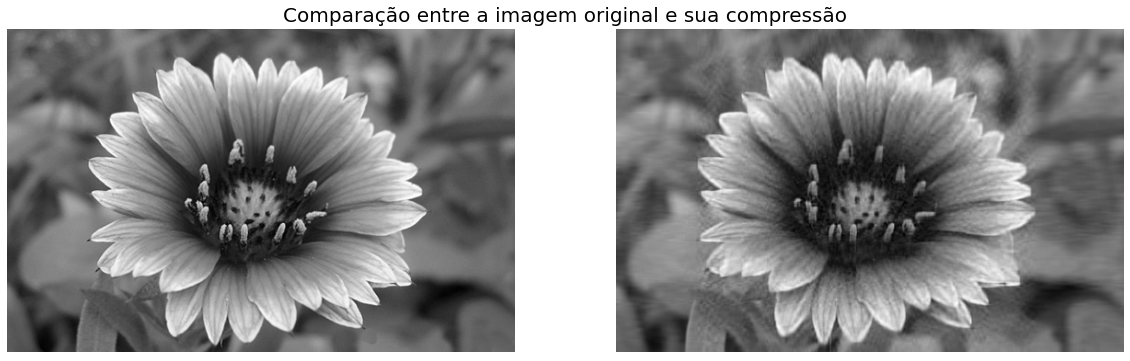

In [44]:
def photo_compression_color(image_path, k):       #funcao responsavel pela compressao usando os 3 canais de cor (RGB) de uma foto usando SVD, dado um caminho para a foto e um k de compressao 
    image = imageio.imread(image_path)
    image_compressed = np.zeros(np.shape(image))
    channel          = np.zeros((np.shape(image)[0],np.shape(image)[1])) 
    
    for i in range(3):    #para cada dos 3 canais de cor 
        channel = image[:,:,i]    #copia apenas os valores deste canal 
        U,S,V   = np.linalg.svd(channel)    #realiza svd para este canal
        S = np.diag(S)
        image_compressed[:,:,i] = U[:,:k].dot(S[:k,:k].dot(V[:k,:]))  #insere na imagem comprimida os k primeiros valores singulares deste canal

    return np.uint8(image_compressed)    

def photo_compression_grayscale(image_path, k):   #funcao responsavel pela compressao em tons de cinza de uma foto usando SVD, dado um caminho para a foto e um k de compressao
    image = imageio.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #transforma a imagem de 3 canais para 1 canal de cinza
    U,S,V = np.linalg.svd(image_gray) #realiza svd
    S = np.diag(S)
    Ak          = U[:,:k].dot(S[:k,:k].dot(V[:k,:])) #insere na imagem comprimida os k primeiros valores singulares
    return Ak    


def compareCompression(image_path, k, color_mode = False):
    image = imageio.imread(image_path)
    painel = plt.figure(1, figsize=(20,6), facecolor='white')                           #Cria uma especie de painel para mostrar as duas imagens (original e comprimida)
    plt.title('Comparação entre a imagem original e sua compressão', fontsize = 20)     #Da um nome a esse painel
    plt.axis('off')                                                                     #Faz com que os eixos cartesianos nao aparecam na imagem
    painel.add_subplot(1,2,1)                                                           #Cria o primeiro subplot (figura no painel), esta eh a imagem original
    plt.axis('off')                                                                     
    if color_mode:                                                                      #Se for modo de cor:
        plt.imshow(image)                                                                   #Exibe a imagem original
        painel.add_subplot(1,2,2)                                                           #Cria o segundo subplot (figura no painel), esta eh a imagem comprimida
        plt.axis('off')                                                                 
        image_Ak = photo_compression_color(image_path, k)                                   #Chama a funcao responsavel por fazer a compressao por decomposicao SVD nos 3 canais de cor (R,G,B)
        plt.imshow(image_Ak)                                                                #Exibe a imagem comprimida
    else:                                                                               #Se for em escala de cinza:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)                                     #Converte a imagem original (de 3 canais: RGB) para apenas 1: escala de cinza
        plt.imshow(image, cmap='gray')                                                      #Exibe a imagem original em escala de cinza
        painel.add_subplot(1,2,2)                                                           #Cria o segundo subplot (figura no painel), esta eh a imagem comprimida
        plt.axis('off') 
        image_Ak = photo_compression_grayscale(image_path,k)                                #Chama a funcao responsavel por fazer a compressao por decomposicao SVD em escala de cinza
        plt.imshow(image_Ak,cmap='gray')                                                    #Exibe a imagem comprimida
    
    plt.axis('off')




np.seterr(all = 'warn')

#so inserir um URL de alguma imagem na internet para realizarmos a compressao
compareCompression("https://upload.wikimedia.org/wikipedia/commons/f/fd/Pink_flower.jpg", 50, False) #Exemplo em tons de cinza

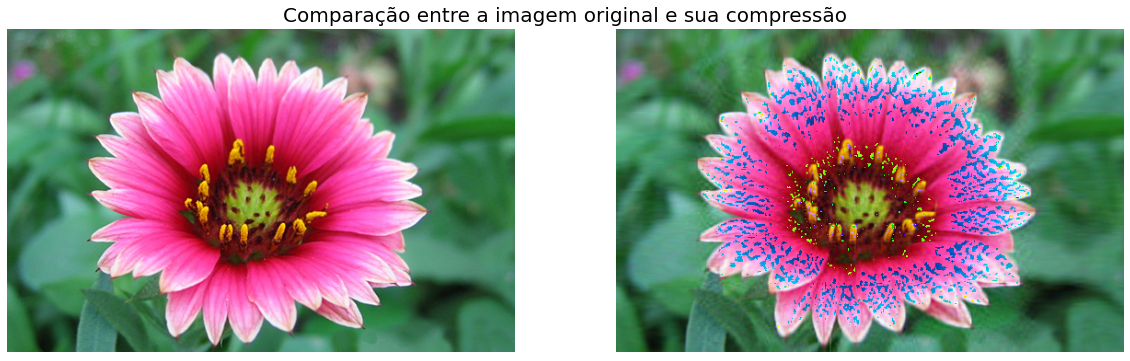

In [45]:
compareCompression("https://upload.wikimedia.org/wikipedia/commons/f/fd/Pink_flower.jpg", 50, True) #agora em modo RGB, optar por usar fotos .jpg pois apresentam apenas 3 canais!!
#perceba o efeito que esta compressao causa nas cores!!

##Métodos das Potências e Potências Inversa
###Método das Potências 
Dada uma matriz A diagonalizável quadrada de ordem $n$, toda matriz simétrica também é diagonalizável, logo as matrizes que funcionam para o Método de Francis também funcionam para este método. Possui autovalores associados a um conjunto L.I. de autovetores (normalizados a fim de facilitar). Para os autovalores de $A$, dizemos que $\lambda_{1}$ é chamado de autovalor dominante, em que seu módulo é estritamente **maior** que todos os outros autovalores, porém, para os outros autovalores é permitida a repetição em módulo ($\geq$), assumimos que os autovalores de A são ordenados por:

$|\lambda_{1}| > |\lambda_{2}| \geq |\lambda_{3}| \geq .... \geq |\lambda_{n}|$ (Perceba que permite repetição a partir de $\lambda_{2}$)

O principal objetivo deste método é apenas calcular o autovalor dominante de $A$ ($\lambda_{1}$) e seu respectivo autovetor $(v_{1})$, ao contrário do Método de Francis em que desejamos obter **todos** autovalores e autovetores associados da matriz $A$. Seu maior benefício é em termos de desempenho, pois existem diversas aplicações em que não precisamos de todos autovalores, apenas do autovalor dominante.

Primeiramente, antes de falarmos do algoritmo em si, devemos mostrar um conceito importante para este método, **o quociente de Rayleigh**:

*   Dado que $Av_{1} = \lambda_{1}v_{1}$
*   Podemos fazer um escalar com $v_{1}$ em ambos os lados $<v_{1},Av_{1}> = <\lambda_{1}v_{1},v_{1}>$
*   Podemos tirar do produto escalar a constante: $<v_{1},A.v_{1}> = \lambda_{1}.<v_{1},v_{1}>$
*   Produto escalar de $v_{1}$ com ele mesmo é $||v_{1}||^2$
*   Isolando $\lambda_{1} = \frac{<v_{1},Av_{1}>}{||v_{1}||^2}$, sendo o lado direito da igualdade conhecido por **quociente de Rayleigh**

Logo, a partir de um autovetor associado, aplicando no quociente de Rayleigh, vamos obter a aproximação do autovalor dominante $\lambda_{1}$. Este método é um processo iterativo no qual calculamos a partir de um chute inicial não nulo diversos vetores $(y_{k})$ que vão se aproximar do autovetor $v_{1}$ e a partir deste, calcular o autovalor dominante $\lambda_{1}$.

*   A cada iteração teremos: $x_{k} = Ay_{k-1}$
*   Então normalizaremos este vetor $x_{k}$: $y_{k} = \frac{x_{k}}{||x_{k}||}$
*   Ao fim do processo iterativo, obtemos uma aproximação do autovetor associado ao autovalor dominante, e então: $\lambda_{1} = <y_{k},Ay_{k}>$, com $||y_{k}|| = 1$, logo omitido no cálculo do quociente de Rayleigh.

A sequência de vetores $y_{k}$ converge para $\pm$ o autovetor associado ao autovalor dominante.

###Método das Potências Inversa
A ideia é basicamente a mesma, entretanto agora a matriz $A$ deve ser inversível também e desejamos calcular agora o **menor** autovalor em módulo e seu autovetor associado da matriz A.
A principal diferença se dá no cálculo de $x_{k}$ em cada iteração, agora vamos calculá-lo por: $x_{k} = A^{-1}y_{k-1}$. Porém como o cálculo de uma matriz inversa exige $n$ resoluções de sistemas lineares, vamos evitar calcular esta, então, calcularemos $x_{k}$, por meio da resolução do sistema linear: $Ax_{k} = y_{k-1}$ em cada iteração.

Como ambos são métodos iterativos, temos como critérios de parada:

*   $k = kmax$
*   $|\lambda_{1,k+1} - \lambda_{1,k}| < Erro$, tal que $Erro > 0$, então deve-se calcular para toda iteração a aproximação do autovalor dominante.
*   $||<y_{k+1},y_{k}>| - 1 | < Erro$, tal que $Erro > 0$, conhecido por teste do alinhamento: Quando o ângulo entre os vetores $y_{k+1}$ e $y_{k}$ se aproxima de zero.  



In [46]:
def potencia(A, error_max, kmax = -1):
    error = np.inf
    n = np.shape(A)[0]
    
    y0 = np.zeros(n)  #Chute inicial nao pode ser o vetor nulo, portanto mudamos uma coordenada para 1, alem disso, ja teremos norma(y) = 1
    y0[0] = 1
    
    if kmax == -1:  #Se desejamos que a condicao de parada seja apenas que o erro da iteracao atual seja menor que o error_max
        while error > error_max:
            x = A.dot(y0)   #Calculamos o vetor x da iteracao atual (x^k = Ay^(k-1))
            y = x/norma(x)  #Calculamos o vetor y da iteracao atual (y eh o vetor x normalizado)
            error = np.abs(np.abs(y.dot(y0)) - 1)  #Teste do alinhamento: se o modulo do cosseno do angulo entre os dois vetores eh proximo de 1, isto eh, se o angulo entre eles eh proximo de zero 
            y0 = y
        lambd = y0.dot(A.dot(y0))  #Calculo do autovalor dominante obtido pelo processo iterativo -> quociente de Rayleigh: aproxima o autovalor dominante (lambda) ao autovetor associado
    else:     #Se desejamos que a condicao de parada seja que o erro da iteracao atual seja menor que o error_max ou que ocorram k_max iteracoes (o que vier primeiro)
        k = 0
        while error > error_max and k < kmax:
            x = A.dot(y0)   #Calculamos o vetor x da iteracao atual (x^k = Ay^(k-1))
            y = x/norma(x)  #Calculamos o vetor y da iteracao atual (y eh o vetor x normalizado)
            error = np.abs(np.abs(y.dot(y0)) - 1)  #Teste do alinhamento: se o modulo do cosseno do angulo entre os dois vetores(y atual, y anterior) eh proximo de 1, isto eh, se o angulo entre eles eh proximo de zero 
            y0 = y
            k += 1
        lambd = y0.dot(A.dot(y0)) #Calculo do autovalor dominante obtido pelo processo iterativo -> quociente de Rayleigh: aproxima o autovalor dominante (lambda) ao autovetor associado
    
    return lambd,y0

def potencia_inversa(A, error_max, kmax = -1):
    error = np.inf
    n = np.shape(A)[0]
    
    y0 = np.zeros(n)  #Chute inicial nao pode ser o vetor nulo, portanto mudamos uma coordenada para 1, alem disso, ja teremos norma(y) = 1
    y0[0] = 1
    
    if kmax == -1:  #Se desejamos que a condicao de parada seja apenas que o erro da iteracao atual seja menor que o error_max
        while error > error_max:
            x = np.linalg.solve(A,y0)   #Calculamos o vetor x da iteracao atual por meio da resolucao do sistema linear Ax^k = y^k-1
            y = x/norma(x)  #Calculamos o vetor y da iteracao atual (y eh o vetor x normalizado)
            error = np.abs(np.abs(y.dot(y0)) - 1)  #Teste do alinhamento: se o modulo do cosseno do angulo entre os dois vetores eh proximo de 1, isto eh, se o angulo entre eles eh proximo de zero 
            y0 = y
        lambd = y0.dot(A.dot(y0))  #Calculo do menor autovalor obtido pelo processo iterativo -> quociente de Rayleigh: aproxima o menor autovalor (lambda) ao autovetor associado
    else:     #Se desejamos que a condicao de parada seja que o erro da iteracao atual seja menor que o error_max ou que ocorram k_max iteracoes (o que vier primeiro)
        k = 0
        while error > error_max and k < kmax:
            x = np.linalg.solve(A,y0)    #Calculamos o vetor x da iteracao atual por meio da resolucao do sistema linear Ax^k = y^k-1
            y = x/norma(x)  #Calculamos o vetor y da iteracao atual (y eh o vetor x normalizado)
            error = np.abs(np.abs(y.dot(y0)) - 1)  #Teste do alinhamento: se o modulo do cosseno do angulo entre os dois vetores(y atual, y anterior) eh proximo de 1, isto eh, se o angulo entre eles eh proximo de zero 
            y0 = y
            k += 1
        lambd = y0.dot(A.dot(y0)) #Calculo do menor autovalor obtido pelo processo iterativo -> quociente de Rayleigh: aproxima o menor autovalor (lambda) ao autovetor associado
    
    return lambd,y0


#A = np.array([[12, 2, 3],  
#              [ 2, 3, 5],
#              [ 3, 5,-2]], dtype='double')

A = np.array([[11, 2, 3, 1, 4],
              [ 2, 9, 3, 5, 2],
              [ 3, 3, 15, 4, 3],
              [1, 5, 4, 12, 4],
              [4, 2, 3, 4, 17]])

D,_ = np.linalg.eig(A)  #so quero os autovalores para comparar, nao preciso dos autovetores

lambd,y = potencia(A, 0.000001)        #retorna o maior autovalor (metodo da potencia)
print('Maior autovalor: %f' %(lambd))
print('Maior autovalor calculado pelo Python: %f' %(np.max(abs(D)))) #procura pelos autovalores de A o maior em modulo

lambd,y = potencia_inversa(A, 0.000001)   #retorna o menor autovalor (metodo da potencia inversa)
print('Menor autovalor: %f' %(lambd))
print('Menor autovalor calculado pelo Python: %f' %(np.min(abs(D)))) #procura pelos autovalores de A o menor em modulo


Maior autovalor: 26.025166
Maior autovalor calculado pelo Python: 26.025175
Menor autovalor: 4.873955
Menor autovalor calculado pelo Python: 4.873946


##**APLICAÇÃO: Google Pagerank**
Este algoritmo tem como objetivo ordenar os resultados de busca por páginas no google, atualmente não é o único usado na empresa para ordenar resultados de busca, porém é um dos melhores existentes.
O pagerank baseia-se na representação dos sites da internet por meio de um grafo direcionado, isto é, em que os sites possuem links externos que levam a outro sites da internet. A partir deste grafo, vamos trabalhar com ele levando em conta um passeio aleatório pelos sites, isto é, em que dado um usuário, qual a probabilidade dele cair em um site $i$. O que importa para este algoritmo não é a quantidade de links que levam a um site, mas sim a "qualidade" destes.

A priori, devemos montar nosso grafo de links externos em uma matriz $G$:

*   Para cada coluna, temos o site de onde o link está (*partida*)
*   Para cada linha, temos para qual site este link leva (*destino*)

Então, se no site $j$ temos um link para o site $i$, então o elemento do grafo $g_{ij} = 1$, caso contrário, $g_{ij} = 0$. Observe que na diagonal, os elementos sempre serão iguais a 0, pois um site não pode levar a ele mesmo.

Entretanto, ainda não temos uma matriz de probabilidades, agora devemos transformar tal matriz que representa o grafo em uma matriz estocástica. Dado que estamos no site $j$ e que este site tem-se $c$ links, logo temos para cada site $i$ que esse site possui link $1/c$ de probabilidade de ir para o site $i$ a partir deste site $j$, então $g_{ij} = 1/c$, caso o site $j$ não tenha link para o site $i$ então temos **0** de probabilidade de ir para o site $i$ a partir deste site $j$, então $g_{ij} = 0$.

Agora, dado que um site $j$ não possui link para **nenhum** site $i$, então durante o passeio aleatorio de nosso usuário, caso passasse pelo site $j$ iria acabar e isto não ocorre, pois este iria reiniciar o processo do passeio, dado que temos $n$ sites, então teríamos $1/n$ de probabilidade de recomeçar o passeio pelo site $i$. Então, caso o site $j$ possua $c = 0$ links, então para todo $i$ teremos $g_{ij} = 1/n$.

A fim de tornar o grafo irredutível, isto é, sem ciclos em que poderiam fazer o usuário ficar preso na navegação, somamos à nossa matriz $G$ uma matriz $M$ em que cada elemento de seus vetores $v_{j}$ possui probabilidade igual, isto é $1/n$, desta forma, eliminamos os zeros da matriz $G$. Porém durante a soma, aplicaremos um fator de ponderação $\alpha$, uma vez que nossa matriz $G$ tem um peso maior sobre a matriz $M$, logo a soma será: $\alpha G + (1-\alpha)M$, que nos dá a matriz estocástica que representa as probabilidades do nosso passeio aleatório pelos sites.

**Como toda matriz estocástica, seu autovalor dominante é igual a 1 e seu autovetor associado nos dará a probabilidade de atingirmos cada site em nosso passeio aleatório (tempo desprendido em cada site). Por fim o rankeamento do algoritmo se dá através das probabilidades dos sites.**

Como precisamos apenas do autovetor associado ao autovalor dominante desta matriz estocástica, utilizaremos o método da potência.

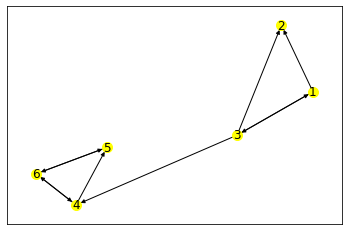


[[0.         0.16666667 0.33333333 0.         0.         0.        ]
 [0.5        0.16666667 0.33333333 0.         0.         0.        ]
 [0.5        0.16666667 0.         0.         0.         0.        ]
 [0.         0.16666667 0.33333333 0.         0.         0.5       ]
 [0.         0.16666667 0.         0.5        0.         0.5       ]
 [0.         0.16666667 0.         0.5        1.         0.        ]]

[[0.025      0.16666667 0.30833333 0.025      0.025      0.025     ]
 [0.45       0.16666667 0.30833333 0.025      0.025      0.025     ]
 [0.45       0.16666667 0.025      0.025      0.025      0.025     ]
 [0.025      0.16666667 0.30833333 0.025      0.025      0.45      ]
 [0.025      0.16666667 0.025      0.45       0.025      0.45      ]
 [0.025      0.16666667 0.025      0.45       0.875      0.025     ]]
O autovetor estocastico obtido pelo processo:
[0.05170475 0.07367926 0.05741241 0.19990381 0.26859608 0.34870369]

A soma de seus elementos(probabilidade): 1.000000
COL

In [64]:
import networkx as nx
import scipy.stats as ss

#atributos da funcao de desenho da representacao visual do grafo
options = {
    'node_color': 'yellow',
    'node_size': 100,
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 8,
}

class sites_graphs:         #classe usada para representar o grafo direcionado de links entre as paginas
  def __init__(self, n_sites):                #construtor do grafo para n paginas de web
    self.S = np.zeros((n_sites,n_sites))                  #inicializa a matriz de conexoes usada posteriormente para o calculo da pagerank
    self.S_representation = nx.DiGraph(directed=True)     #inicializa o grafo usado apenas para representacao visual como direcionado
    for i in range(n_sites):                              #insere os nos (paginas de web) no grafo usado apenas para representacao visual
      self.S_representation.add_node(i+1)                 #os nos sao nomeados como: 1 - para site 1 , 2 - para site 2, ... , n - para site n
  
  def addLink(self, i, j):             #metodo responsavel por inserir um link entre as paginas no grafo. De uma pagina i para uma pagina j. (site i -> site j)
    self.S[j,i] = 1.0                  #insere a conexao na matriz de conexoes
    self.S_representation.add_edge(i+1,j+1)   #insere uma aresta no grafo de representacao visual
  
  def drawPages(self):                #metodo responsavel por desenhar a representacao grafica do grafo de pagina
    nx.draw_networkx(self.S_representation, arrows=True, **options)
    plt.savefig('sites_graph.png')
    plt.show()
  
  def PageRankGraph(self):          #apenas chama a funcao de pageRank ja existente para a matriz de representacao deste objeto
    pageRank(self.S)

#exatamente o mesmo metodo da potencias que conhecemos porem com modificacoes para uma matriz estocastica:
def potencia_estocastica(E, error_max, kmax = -1):
    error = np.inf
    n = np.shape(A)[0]
    
    y0 = np.ones(n)/n  

    if kmax == -1:  
        while error > error_max:
            y = E.dot(y0)   
            #Mudanca em relacao ao metodo da potencia "normal": o vetor x nao eh pra ser normalizado, uma vez que uma matriz estocastica vezes um vetor estocastico, gera um vetor estocastico
            error = np.abs(y.dot(A.dot(y)) - 1)  #Mudanca em relacao ao metodo da potencia "normal": a verificacao de erro passa a ser pelo quociente de Rayleigh, uma vez que conhecemos o autovalor dominante de uma matriz estocastica: 1 
            y0 = y
            #Mudanca em relacao ao metodo da potencia "normal": nao precisamos calcular o autovalor dominante de uma matriz estocastica, uma vez que este sempre sera 1
    else:     
        k = 0
        while error > error_max and k < kmax:
            y = E.dot(y0)
            error = np.abs(y.dot(A.dot(y)) - 1)   
            y0 = y
            k += 1

    return y0

#funcao que calcula o pageRank dada uma matriz de conexoes entre paginas da web e um alpha ponderador explicado na teoria acima.
def pageRank(S_old, alpha = 0.85):
    n = np.shape(S_old)[0]
    S = np.copy(S_old)

    for j in range(n):    #para cada site do grafo de conexoes (para cada coluna da matriz de conexoes)
        c = sum(S[k,j] for k in range(n))     #calcula a soma c de suas linhas 
        for i in range(n):                    #para cada site i para que este site j possui uma conexao
            if c == 0:                        #se o site j nao tem nenhuma conexao a outro site
                S[i,j] = 1/n                  
            elif S[i,j] == 1:                 #se o site j possui uma conexao para o site i
                S[i,j] = 1/c
    
    filled = np.full((n, n), 1/n)             #matriz "preenchida" de vetores de probabilidades iguais
    G = alpha*S + (1-alpha)*filled            #calculo da matriz estocastica final
    print('')
    print(S)
    print('')
    print(G)

    v = potencia_estocastica(G, 1e-6,10000)   #calculo do autovetor estocastico
    print('O autovetor estocastico obtido pelo processo:')
    print(v)
    print('')
    print('A soma de seus elementos(probabilidade): %f' %(np.sum(v)))
    ranked = ss.rankdata(v)   #rankeamento final das paginas
    
    for i in range(n-1,-1,-1):    #exibe o rank final das paginas desta matriz de conexoes
      print('COLOCAÇÃO[%d] - Site %d' %(n-i,ranked[i]))
    


#Exemplo de internet com 6 sites proposto pelo professor Afonso Paiva em seus slides sobre autovalores.
A = np.array([[0, 0, 1, 0, 0, 0],
              [1, 0, 1, 0, 0, 0],
              [1, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0, 1],
              [0, 0, 0, 1, 1, 0]], np.float32)

#utilizando a classe de grafos de conexoes entre as paginas da web
teste = sites_graphs(6)
teste.addLink(0,1)    #conexao do site 1 ao site 2, utilizando a indexacao do python [0,n-1] ao inves de [1,n]
teste.addLink(0,2)    #conexao do site 1 ao site 3
teste.addLink(2,0)
teste.addLink(2,1)
teste.addLink(2,3)
teste.addLink(3,4)
teste.addLink(3,5)
teste.addLink(4,5)
teste.addLink(5,3)
teste.addLink(5,4)
teste.drawPages()
#pageRank(A)
#print('\n')
teste.PageRankGraph()


#**[TÓPICO 3]: Interpolação Polinomial**
----------------------
<p>Dado um conjunto discreto de pontos, a ideia é achar uma função interpoladora que passe por todos esses pontos, desta forma, aproximar o valor dos pontos que não foram representados discretamente. Ou quando possuímos uma função muito complicada, em que seus processos de derivação e integração são muito difíceis, a interpolação surge a fim de aproximar esta função a um polinômio para que o cálculo da integral e derivada sejam bem mais triviais, para tal, avaliamos a função complicada em alguns pontos discretos e achamos uma função interpoladora que passe por esses pontos.</p> 
<p>Como podemos ver, o objetivo da interpolação é, dado um conjunto de pontos discretos (chamados de nós da interpolação)
$(x_{0},y_{0}), (x_{1},y_{1}),..., (x_{n},y_{n})$, em que $x_{0} < x_{1} <...< x_{n}$, achar uma função interpoladora polinomial $F: {\rm I\!R} \rightarrow {\rm I\!R}$ de $grau <= n$, que $y_{i} = F(x_{i})$, isto é, que passe sob os pontos dados. Segundo o teorema, nos garante que este polinômio que passa por este conjunto de pontos é único. </p>
<p>O jeito mais simples de se calcular o polinômio interpolador $P_{n}(x) = 1 + a_{1}x + a_{2}x^2 + ... + a_{n}x^n$ é por meio da resolução do sistema linear: $Xa = y$, tais que:

$X = \begin{pmatrix}
1 & x_{0} & x_{0}^2 &  \ldots & x_{0}^n \\
1 & x_{1} & x_{1}^2 &  \ldots & x_{1}^n \\
\vdots & \vdots & \vdots &  \ddots & \vdots  \\
1 & x_{n} & x_{n}^2 &  \ldots & x_{n}^n
\end{pmatrix}$

$a = \begin{pmatrix}
a_{0} \\
a_{1} \\
\vdots \\
a_{n} 
\end{pmatrix}$

$ y =\begin{pmatrix}
y_{0} \\
y_{1} \\
\vdots \\
y_{n} 
\end{pmatrix}$


<p>Além disso, como o determinante da matriz $X$ é diferente de zero, o sistema é SPD e por isso garantimos que temos uma única solução, isto é, um único polinômio que satisfaz todas as condições, demonstrando o teorema da unicidade. Entretanto, vejamos que este não é um método eficiente, uma vez que para um conjunto $n + 1$ muito grande de pontos, seria um sistema linear muito custoso de se resolver.</p>

P(x) = -229.000 + (168.500*)x^1 + (-39.500*)x^2 + (3.000*)x^3



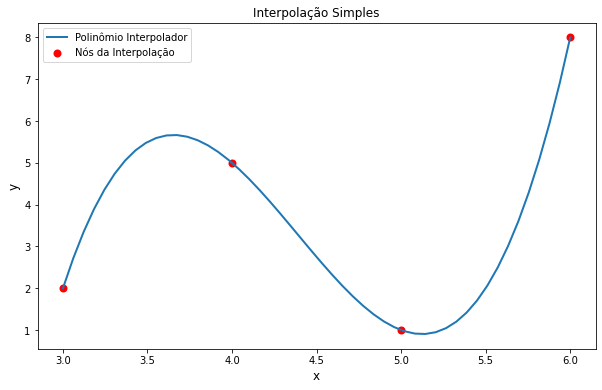

In [48]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import scipy.interpolate

def PolynomialEvaluate(Polynomial, x): #funcao responsavel por avaliar o polinomio interpolante encontrado pela interpolacao simples nos x passados
  n = len(x)                    #quantos x devem ser avaliados
  y = np.zeros(n)               
  m = np.shape(Polynomial)[0]   #grau do nosso polinomio

  for i in range(n):      #para cada x
    for j in range(m):    #calcula y = P(x)
      y[i] += Polynomial[j]*pow(x[i],j)
  
  return y  #retorna os y respostas dos x passados


def printPolynomial(Polynomial): #Funcao responsavel por imprimir o polinomio com base no vetor de coeficientes 'a' passado
  n = np.shape(Polynomial)[0]
  print('P(x) = ', end='')
  for i in range(n):
    if i == 0:
      print('%.3f' % (Polynomial[0]), end='')
    else:  
      print(' + (%.3f*)x^%d' % (Polynomial[i], i), end ='')
  
  print('\n')


def simpleInterpolation(P): 
  n = len(P)          #tamanho do conjunto de pontos passado
  X = np.zeros((n,n)) #inicializa a matriz X e o vetor y
  y = np.zeros(n)

  #preenche a matriz X e vetor y com base na nossa lista de pontos passada
  for i in range(n):
    y[i] = P[i][1]      #preenche o vetor y com as coordenadas y dos pontos passados
    for j in range(n):  #preenche a matriz X por meio das coordenadas dos pontos passados
        X[i,j] = pow(P[i][0], j)  #eleva a coordenada x do ponto de acordo com a coluna j da matriz 

  return np.linalg.solve(X,y) #basta apenas resolver o sistema que obtemos o vetor 'a' de coeficientes do polinomio interpolador

xi = []
yi = []
P = []

#cria conjunto de pontos que queremos encontrar um polinomio interpolador que passe por estes
P.append((3,2))
xi.append(3)
yi.append(2)
P.append((4,5))
xi.append(4)
yi.append(5)
P.append((5,1))
xi.append(5)
yi.append(1)
P.append((6,8))       
xi.append(6)
yi.append(8)

Poly = simpleInterpolation(P) #calcula o polinomio interpolador por meio do metodo "simples" (resolucao de sistema linear)
printPolynomial(Poly)         #imprime o polinomio em forma de string

x = np.linspace(3, 6, num=50, endpoint=True) #nos retorna 50 coordenadas em x entre 3 e 6 uniformemente espacados 
y = PolynomialEvaluate(Poly,x) #a partir destas coordenadas em x, vamos avaliar no nosso polinomio interpolador achado

#Plot do grafico
plt.figure(figsize=(10,6),facecolor='white')
plt.scatter(xi,yi,label = 'Nós da Interpolação',linewidth = 2, c = 'red') #Plota os pontos que o polinomio interpolador deve passar
plt.plot(x,y,label = 'Polinômio Interpolador',linewidth = 2)  #Plota a curva do polinomio interpolador a partir dos pontos avaliados calculados acima
plt.xlabel('x',fontsize='large') 
plt.ylabel('y',fontsize='large') 
plt.title('Interpolação Simples') 
plt.legend() 
plt.show()


##Interpolação de Lagrange
<p>Este método é uma alternativa ao cálculo do polinômio interpolador por meio de um sistema linear. A forma do polinômio interpolador encontrado para um conjunto de pontos $(x_{0},y_{1}),...,(x_{n},y_{n})$ através deste método é: $P_{n}(x) = y_{0}.l_{0}(x) + y_{1}.l_{1}(x) +...+ y_{n}.l_{n}(x)$ em que $l_{k}(x)$ são polinômios dependentes de x chamados de polinômios de lagrange.</p>
<p>Para cada ponto do nosso conjunto queremos que nosso polinômio interpolador $P_{n}(x_{i}) = y_{i}$, então para isso ocorrer, o polinômio de lagrange $l_{k}(x_{i})$ deverá ser:</p>

*   $1$ para $i = k$
*   $0$ para $i \neq k$

<p>Por exemplo se desejamos avaliar em nosso polinômio interpolador $P_{n}(x_{0})$, então teremos $P_{n}(x_{0}) = y_{0}.1 + y_{1}.0 +...+ y_{n}.0 = y_{0}$ tal como queríamos. Desta forma, $\{x_{0},...,x_{n}\} - \{x_{k}\}$ são as raízes deste polinômio de lagrange, e portanto, podemos calculá-lo por: $l_{k}(x) = \prod_{i = 0, i \neq k}^{n} \frac{x - x_{i}}{x_{k} - x_{i}}$ para $k=0,...,n$.</p>
<p>Entretanto, caso desejemos adicionar mais um ponto $(x_{n+1}, y_{n+1})$ ao nosso conjunto, <b>todos</b> os polinomios de lagrange necessitam ser recalculados. </p>  


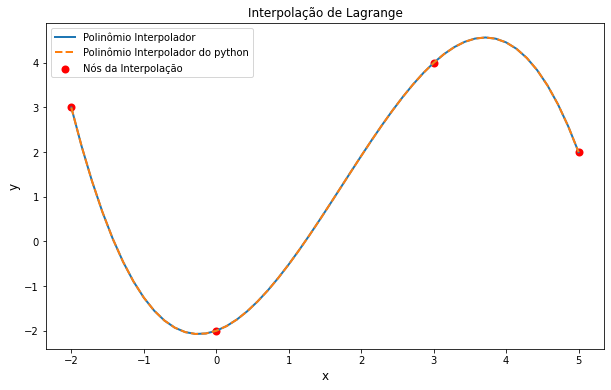

In [49]:
#P - conjunto de pontos discretos que queremos achar um polinomio interpolador que passa por estes
#x - conjunto de pontos em que queremos avaliar nosso polinomio
def lagrangePolynomialInterpolation(P,x):
  n = len(P)
  m = np.shape(x)[0]
  L = np.ones((n,m))
  y = np.zeros(n)

  for i in range(n):  #Para cada polinomio de lagrange
    y[i] = P[i][1]    #Armazena os yi de cada ponto neste vetor
    for j in range(n):  #Realiza o produtorio
      if i != j:
        L[i,:] *= (x - P[j][0])/(P[i][0] - P[j][0])

  return y.dot(L) #Pn(x) = y0.l0(x) + y1.l1(x) + ... yn.ln(x) que nos da o polinomio desejado avaliado nos pontos passados por meio do somatorio do produto de yi*li(x)

xi = []
yi = []
P = []

#cria conjunto de pontos que queremos encontrar um polinomio interpolador que passe por estes
xi.append(-2)
yi.append(3)
P.append((xi[0],yi[0]))
xi.append(0)
yi.append(-2)
P.append((xi[1],yi[1]))
xi.append(3)
yi.append(4)
P.append((xi[2],yi[2]))
xi.append(5)
yi.append(2)
P.append((xi[3],yi[3]))

x = np.linspace(-2, 5, num=50, endpoint=True) #nos retorna 50 coordenadas em x entre -2 e 5 uniformemente espacados 
y = lagrangePolynomialInterpolation(P,x)    #avalia o polinomio interpolador por meio da interpolacao de lagrange a partir destas coordenadas em x

poly = sp.interpolate.lagrange(xi,yi)   #Faz o mesmo exemplo com a funcao pronta do python a fim de comparar os resultados
y_python = PolynomialEvaluate(poly,x)

#Plot do grafico
plt.figure(figsize=(10,6),facecolor='white')
plt.scatter(xi,yi,label = 'Nós da Interpolação',linewidth = 2, c = 'red') #Plota os pontos que o polinomio interpolador deve passar
plt.plot(x,y,label = 'Polinômio Interpolador',linewidth = 2) #Plota a curva do polinomio interpolador a partir dos pontos avaliados calculados acima
plt.plot(x,y_python,label = 'Polinômio Interpolador do python',linestyle = 'dashed',linewidth = 2) #Compara com o polinomio interpolador achado pela funcao pronta do python
plt.xlabel('x',fontsize='large') 
plt.ylabel('y',fontsize='large') 
plt.title('Interpolação de Lagrange') 
plt.legend() 
plt.show()

##Interpolação de Newton
<p>Como o a interpolação de Lagrange possui o problema da necessidade de recalcular todos os polinômios de Lagrange quando mais um ponto é adicionado ao nosso conjunto de nós da interpolação, a interpolação de Newton tem por intuito impedir esse problema.</p>

<p>O polinômio interpolador obtido através desse processo dado um conjunto de pontos em que desejamos que o polinômio passe $(x_{0},y_{0}),...,(x_{n},y_{n})$ é: <br> $P_{n}(x) = \alpha_{0} + \alpha_{1}(x - x_{0}) + \alpha_{2}(x - x_{0})(x - x_{1}) + \alpha_{3}(x - x_{0})(x - x_{1})(x - x_{2}) + ... + \alpha_{n}(x - x_{0})(x - x_{1})(x - x_{2})...(x - x_{n-1})$ <br> em que $\alpha_{k} = f[x_{0},...,x_{k}]$ para $k = 0,...,n$ e $f[x_{0},...,x_{k}]$ é chamada de diferença dividida e possui fórmula geral $f[x_{i},...,x_{i+k}] = \frac{f[x_{i+1},...,x_{i+k}] - f[x_{i},...,x_{i+k-1}]}{x_{i+k} - x_{i}}$ para $k = 1,...,n-1$ e $i = 0,...,n-k$.</p>

<p>Perceba que a diferença dividida é calculada recursivamente, logo o cálculo de uma diferença recursiva de ordem maior depende necessariamente do cálculo de uma diferença dividida de ordem menor à ela, e portanto, desta forma, a interpolação de Newton é um método que podemos reaproveitar o cálculo feito anteriormente caso deseje adicionar um novo ponto ao nosso conjunto de nós de interpolação, uma vez que o cálculo do novo $\alpha_{n+1}$ dependerá dos anteriormente calculados. E desta forma, a interpolação de newton não possui o mesmo problema da interpolação de lagrange comentado acima.</p>

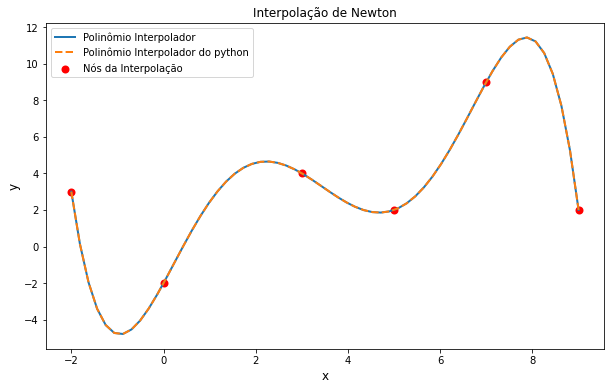

In [50]:
#Calcula a interpolacao com base em um conjunto de nos de interpolacao e uma tabela de diferencas divididas previamente calculadas
#P - conjunto de n nos de interpolacao
#x - pontos em queremos avaliar nosso polinomio
#D - se for a primeira vez que calculamos a interpolacao de newton para esse conjunto inicial de n nos de interpolacao, entao deve ser passado o argumento None
#  - caso contrario, se o mesmo conjunto inicial de nos de interpolacao teve k pontos adicionados posteriormente (os n antigos + k novos) deve ser enviada a tabela de diferencas divididas
#calculadas para os n nos de interpolacao iniciais, desta forma, reaproveitando o que fora calculado anteriormente
def newtonPolynomialInterpolation(P,x,D):
    n = len(P)
    ni = np.size(x)
    N = np.ones((n,ni))
    n_c = 0   #o quanto da nossa matriz de diferencas divididas foi anteriormente calculado, isto eh, a interpolacao de newton foi feita para um conjunto menor de nos de interpolacao

    if D is None: #Se nao foi passada nenhuma matriz de diferencas divididas deste polinomio interpolador previamente calculado para menos pontos 
      D = np.zeros((n,n))
    elif np.shape(D)[0] < n:  #Se foram adicionados novos pontos ao conjunto de nos de interpolacao desde a ultima vez que fora calculado a interpolacao de newton
      n_c = np.shape(D)[0]  #Para quantos nos de interpolacao o metodo de newton foi anteriormente calculado
      D.resize((n,n))       #Redefine a ordem da matriz para caber as diferencas divididas de maior ordem que serao calculadas com base nas de menor ordem previamente calculadas
    else: 
      raise exception('O conjunto de nos de interpolacao pode ser incrementado, mas nao reduzido!')
       
    #n_c eh de suma importancia, pois previne recalcular diferencas divididas que foram anteriormente calculadas para n pontos
    #caso agora tenhamos n iniciais + k novos nos de interpolacao, calculara apenas as diferencas divididas para os k novos nos de interpolacao

    for i in range(n_c,n):
      D[i,0] = P[i][1]    #Preenche as diferencas divididas de ordem 0 com as coordenadas y dos nos de interpolacao

    #Calculo das diferencas divididas recursivamente a partir do preenchimento da tabela
    for j in range(n_c, n-1):         #Perceba: o inicio se da em n_c, isto eh, o quanto ja calculamos e quanto ainda precisamos preencher pra esse conjunto de nos de interpolacao
        for i in range(n_c, n-j-1):    
            D[i,j+1] = (D[i+1,j]-D[i,j])/(P[i+j+1][0]-P[i][0])

    for i in np.arange(1,n):    #calcula (x - xo).(x - x1)...(x - xk-1) que sera multiplicado por cada alpha k
        N[i,:] = N[i-1,:]*(x-P[i-1][0])
    
    return D[0,:].dot(N)  #multiplica alpha k com a respectivo produtorio realizado para ele, retornando assim o polinomio avaliado nos pontos passados
  
xi = []
yi = []
P  = []

#cria conjunto de pontos que queremos encontrar um polinomio interpolador que passe por estes
xi.append(-2)
yi.append(3)
P.append((xi[0],yi[0]))
xi.append(0)
yi.append(-2)
P.append((xi[1],yi[1]))
xi.append(3)
yi.append(4)
P.append((xi[2],yi[2]))
xi.append(5)
yi.append(2)
P.append((xi[3],yi[3]))

x = np.linspace(-2, 9, num=60, endpoint=True) #nos retorna 60 coordenadas em x entre -2 e 9 uniformemente espacados 
D = None
y = newtonPolynomialInterpolation(P,x,D)    #avalia o polinomio interpolador por meio da interpolacao de newton a partir destas coordenadas em x com base nos 4 nos de interpolacao iniciais 

xi.append(7)
yi.append(9)
P.append((xi[4],yi[4]))
xi.append(9)
yi.append(2)
P.append((xi[5],yi[5]))

y = newtonPolynomialInterpolation(P,x,D)   #avalia o polinomio interpolador por meio da interpolacao de newton com base com o mesmo conjunto de nos de interpolacao anterior porem com mais dois pontos novos (totalizando 6 nos de interpolacao)
#desta forma, reutilizamos as diferencas divididas que foram calculadas anteriormente para os 4 nos de interpolacao iniciais

poly = sp.interpolate.lagrange(xi,yi)   #Faz o mesmo exemplo com a funcao pronta do python a fim de comparar os resultados
y_python = PolynomialEvaluate(poly,x)

#Plot do grafico
plt.figure(figsize=(10,6),facecolor='white')
plt.scatter(xi,yi,label = 'Nós da Interpolação',linewidth = 2, c = 'red') #Plota os pontos que o polinomio interpolador deve passar
plt.plot(x,y,label = 'Polinômio Interpolador',linewidth = 2) #Plota a curva do polinomio interpolador a partir dos pontos avaliados calculados acima
plt.plot(x,y_python,label = 'Polinômio Interpolador do python',linestyle = 'dashed',linewidth = 2) #Compara com o polinomio interpolador achado pela funcao pronta do python
plt.xlabel('x',fontsize='large') 
plt.ylabel('y',fontsize='large') 
plt.title('Interpolação de Newton') 
plt.legend() 
plt.show()

##Fenômeno de Runge

Quando utilizamos a interpolação, nem sempre ficamos muito satisfeitos com o resultado. O polinômio pode se distanciar(em algumas partes) mais do que desejamos e então começamos a nos questionar se é possível fazer uma aproximação melhor, isto é, com valor do erro menor. Seguindo essa linha, a primeira dúvida que temos é a seguinte:

Se aumentarmos o grau do polinômio, teremos uma aproximação melhor para a função $f(x)$? Ou seja,  $P_{n}(x)$ converge para $f(x)$ quando aumentamos o número de nós de interpolação ($n\rightarrow \infty$)?

A resposta é não. Se aumentarmos o número de nós de interpolação, não necessariamente vamos melhorar a aproximação da função, podendo até mesmo piorar, ou seja, apresentar erro maior.

Sendo assim, não podemos afirmar que  $P_{n}(x)$ converge para $f(x)$ quando $n\rightarrow \infty$, pois interpolação polinomial de alta ordem é instável em uma distribuição uniforme de nós.


Para 8 nos de interpolacao temos: 

Ponto na função:(-1.000,0.038)
Aproximação em lagrange: (-1.000,0.038) --- Erro: 0.000000
Aproximação em newton: (-1.000,0.038) --- Erro: 0.000000

Ponto na função:(-0.990,0.039)
Aproximação em lagrange: (-0.990,0.076) --- Erro: 0.036417
Aproximação em newton: (-0.990,0.076) --- Erro: 0.036417

Ponto na função:(-0.980,0.040)
Aproximação em lagrange: (-0.980,0.108) --- Erro: 0.067602
Aproximação em newton: (-0.980,0.108) --- Erro: 0.067602

Ponto na função:(-0.970,0.041)
Aproximação em lagrange: (-0.970,0.135) --- Erro: 0.093939
Aproximação em newton: (-0.970,0.135) --- Erro: 0.093939

Ponto na função:(-0.960,0.042)
Aproximação em lagrange: (-0.960,0.157) --- Erro: 0.115795
Aproximação em newton: (-0.960,0.157) --- Erro: 0.115795

Ponto na função:(-0.950,0.042)
Aproximação em lagrange: (-0.950,0.176) --- Erro: 0.133523
Aproximação em newton: (-0.950,0.176) --- Erro: 0.133523

Ponto na função:(-0.940,0.043)
Aproximação em lagrange: (-0.940,0.191) --- E

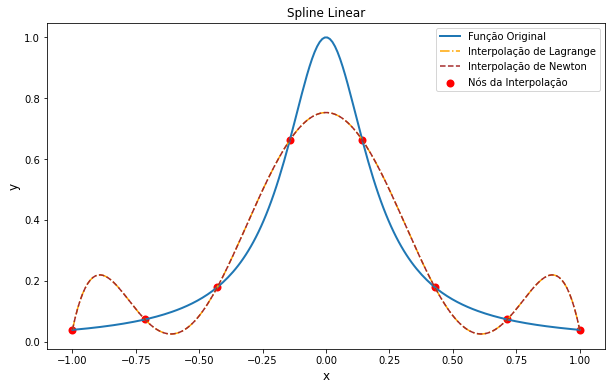

In [51]:
def error_comparator(P, y_evaluated, x):   #funcao responsavel por comparar a avaliacao na interpolacao de lagrange e de newton com os pontos avaliados na funcao original 
  y_lagrange = lagrangePolynomialInterpolation(P,x)         #avalia na interpolacao de lagrange os pontos x dado os P nos interpoladores 
  y_newton   = newtonPolynomialInterpolation(P,x,None)      #avalia na interpolacao de newton os pontos y dado os P nos interpoladores
  #veremos que ambos dao o mesmo resultado, newton eh apenas uma otimizacao de lagrange!!!

  n = np.shape(x)[0]

  print('Para %d nos de interpolacao temos: \n' % (len(P)))
  for i in range(n):                                                    #para cada ponto avaliado na funcao original
    print('Ponto na função:(%.3f,%.3f)' %(x[i],y_evaluated[i]))
    print('Aproximação em lagrange: (%.3f,%.3f) --- Erro: %f' %(x[i], y_lagrange[i], abs(y_evaluated[i] - y_lagrange[i])))    #erro entre o ponto avaliado na funcao original e em lagrange
    print('Aproximação em newton: (%.3f,%.3f) --- Erro: %f\n' %(x[i], y_newton[i], abs(y_evaluated[i] - y_newton[i])))        #erro entre o ponto avaliado na funcao original e em newton
                                                                                                                              #em ambos teremos o mesmo erro!!
  n = len(P)
  xi = []
  yi = []
  for i in range(n):    #insere os nos interpoladores nas listas auxiliares para plot
    xi.append(P[i][0])
    yi.append(P[i][1])

  plt.figure(figsize=(10,6),facecolor='white')
  plt.scatter(xi,yi,label = 'Nós da Interpolação',linewidth = 2, c = 'red') 
  plt.plot(x,y_evaluated,label = 'Função Original',linewidth = 2)
  plt.plot(x,y_lagrange,label = 'Interpolação de Lagrange', linestyle='dashdot', c = 'orange')
  plt.plot(x,y_newton,label = 'Interpolação de Newton', linestyle='dashed', c = 'brown')
  plt.xlabel('x',fontsize='large') 
  plt.ylabel('y',fontsize='large') 
  plt.title('Spline Linear') 
  plt.legend() 
  plt.show()
  
def evaluate_function(x,f):   #a partir de uma funcao lambda f passada como parametro, avalia os pontos nesta funcao
  n = np.shape(x)[0]          
  y = np.zeros(n)
  
  for i in range(n):  #para cada ponto, avalia ele na funcao
    y[i] = f(x[i])

  return y  #retorna os pontos avaliados


f = lambda x: 1/(1 + 25*pow(x,2))
x = np.linspace(-1, 1, num=200, endpoint=True)
y = evaluate_function(x,f)

degree = 8  #grau do polinomio interpolador, isto eh, numero de nos interpoladores
x_nodes = np.linspace(-1,1,num = degree, endpoint=True) #pega degree nos igualmente espacados
y_nodes = evaluate_function(x_nodes,f)    #avalia estes nos na funcao original a fim de obtermos suas coordenadas y

P = []
for i in range(degree): #insere na lista de nos interpoladores
  P.append((x_nodes[i],y_nodes[i]))

error_comparator(P,y,x)

##Splines

Como aumentar o número de nós de interpolação não é eficiente para obter uma aproximação melhor, existe um método chamado "Splines".

O Splines é, basicamente, a realização da interpolação polinomial por partes. Nós tínhamos um intervalo de nós, de $x_{0}$ ate $x_{n}$, e vamos dividir esse "intervalo grande" em subintervalos e para cada subintervalo vamos aproximar por um polinômio, depois é feita a "conexão" entre todos eles.

Dados $(n+1)$ pontos $(x_{0}, y_{0}), ..., (x_{n}, y_{n})$ com $a = x_{0} < ... < x_{n} = b$. Uma função $S_{k}(x)$ é chamada de spline de grau $K$ se satisfaz as seguintes condições:

*  $S_{k,i} = S_{k}[x_{i}, x_{i+1}]$, com $i = 0, ..., n-1$, é um polinomio de grau $K$;
*  $S_{k} \in C^{k-1} ([a,b]);$
*  $S_{k}(x_{i}) = y_{i}$, com $i = 0, ..., n$.

Sendo assim, o grau de cada polinômio dos subintervalos devem ser iguais. Por exemplo, uma spline linear é $S_{1}(x)$ com um polinômio de grau 1 em cada subintervalo $[x_{i}, x_{i+1}]$m, $S_{1} \in C^0 ([a,b])$. Enquanto uma spline cubica $S_{3}(x)$ possui um polinomio de terceiro grau em cada um dos subintervalos $[x_{i}, x_{i+1}]$m, $S_{3} \in C^2 ([a,b])$.

A spline linear possui derivada primeira descontínua, por isso apresenta pico e transição abrupta nos nós. Para melhorar esse problema, dando mais suavidade a curva que queremos interpolar, devemos utilizar a spline cúbica. A cúbica apresenta derivadas primeira e segunda contínuas, portanto não tem picos e não troca de forma abrupta na transição dos nós, faz uma curvatura suave. A spline cúbica é muito utilizada em ferramentas, como no photoshop, onde auxilia para fazer o contorno de objetos.

###Spline Linear
---
<p>Possui um polinômio de primeiro grau (por isso linear) em cada subintervalo $[x_{i}, x_{i+1}]$ para $i = 0,...,n-1$ dado um conjunto de pontos $(x_{0},y_{0}),...,(x_{n},y_{n})$ de fórmula: </p>
<p> $S_{1,i}(x) = y_{i}\frac{x_{i+1} - x}{x_{i+1} - x{i}} + y_{i+1}\frac{x - x_{i}}{x_{i+1} - x{i}}$ </p>
<p>A fim de facilitar os cálculos podemos chamar $\frac{x - x_{i}}{x_{i+1} - x{i}} = t$, logo podemos reescrever nossa fórmula acima como: </p>
<p>$S_{1,i}(x) = y_{i}(1-t) + y_{i+1}t$</p>

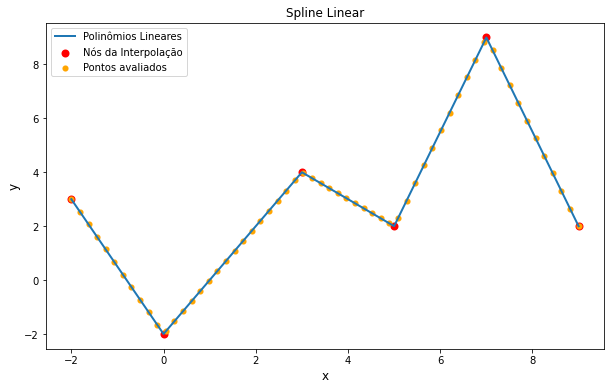

In [52]:
def linear_spline(P,x):    #funcao responsavel por calcular a spline linear dado os nos de interpolacao e os pontos que queremos avaliar nesta spline
  n = len(P)
  m = np.shape(x)[0]
  S = np.zeros((n-1,m))

  for i in range(n-1):    #para cada subintervalo
    t = (x - P[i][0])/(P[i+1][0] - P[i][0])   
    S[i,:] = (1 - t)*P[i][1] + t*(P[i+1][1])      #calcula a reta que passa entre os dois nos de interpolacao

  return S    #retorna os pontos avaliados nestas retas

def evaluate_linear_spline(P,S,x):  #funcao responsavel por avaliar em qual spline o ponto que queremos avaliar pertence
  n = np.shape(x)[0]
  y = np.zeros(n)

  j = 0
  i = 0
  while i < n:    #para todos os pontos que queremos avaliar
    if x[i] <= P[j+1][0]: #este ponto esta dentro do intervalo desta spline? (x < xi)?
      y[i] = S[j,i]   #avalia o ponto na spline devida
      i += 1
    else:     #senao este pertence a proxima spline
      j += 1

  return y    #retorna os pontos x avaliados na nossa spline linear


xi = []
yi = []
P  = []



#insere nos de interpolacao
xi.append(-2)
yi.append(3)
P.append((xi[0],yi[0]))
xi.append(0)
yi.append(-2)
P.append((xi[1],yi[1]))
xi.append(3)
yi.append(4)
P.append((xi[2],yi[2]))
xi.append(5)
yi.append(2)
P.append((xi[3],yi[3]))
xi.append(7)
yi.append(9)
P.append((xi[4],yi[4]))
xi.append(9)
yi.append(2)
P.append((xi[5],yi[5]))

x = np.linspace(-2, 9, num=60, endpoint=True) #pontos nos quais queremos avaliar nossa spline
S = linear_spline(P,x)        #obtem nossa spline linear
y = evaluate_linear_spline(P,S,x) #avalia os pontos na nossa spline linear

plt.figure(figsize=(10,6),facecolor='white')
plt.scatter(xi,yi,label = 'Nós da Interpolação',linewidth = 2, c = 'red') #Plota os pontos que o polinomio interpolador deve passar
plt.scatter(x,y,label = 'Pontos avaliados', linewidth = 0.1, c='orange')  #Plota os pontos que foram avaliados na spline
plt.plot(xi,yi,label = 'Polinômios Lineares',linewidth = 2) #Plota a spline linear, basta passar uma reta a cada dois nos interpoladores
plt.xlabel('x',fontsize='large') 
plt.ylabel('y',fontsize='large') 
plt.title('Spline Linear') 
plt.legend() 
plt.show()

## Spline cúbica
---
Uma função $S_{3}(x)$ é uma spline cúbica se satisfaz as seguintes condições:

* $S_{3,i} = S_{3}[x_{i},x_{i+1}]$, com $i = 0, ..., n-1$ é um polinômio de grau 3.
* $S_{3}(x_{i}) = y_{i}$, com $i = 0, ..., n$.
* $S_{3} \in C^2([a, b])$.

Existem $n-1$ polinômios cúbicos $S_{3,i}(x)$ que satisfazem as condições:

* $S_{3,i}(x_{i}) = y_{i}$ e $S_{3,i}(x_{i+1}) = y_{i+1}$ com $i = 0, ..., n-1$.
* $S_{3,i}(x_{i+1}) = S_{3,i+1}(x_{i+1})$ com $i = 0, ..., n-2$, isto é função contínua.
* $S'_{3,i}(x_{i+1}) = S'_{3,i+1}(x_{i+1})$ com $i = 0, ..., n-2$, isto é, primeira derivada contínua.
* $S''_{3,i}(x_{i+1}) = S''_{3,i+1}(x_{i+1})$ com $i = 0, ..., n-2$, isto é, segunda derivada contínua.
* Condições de contorno:
 * Naturais $S''_{3}(x_{0}) = S''_{3}(x_{n}) = 0$
 * Fixadas $S'_{3}(x_{0}) = f'(x_{0})$ e $S'_{3}(x_{n}) = f'(x_{n})$



Vamos denotar $S_{i}(x)$ como:

$S_{3,i}(x) = a_{i}(x-x_{i})^3 + b_{i}(x-x_{i})^2 + c_{i}(x-x_{i}) + d_{i}, i = 0,...,n-1$.

Para determinar $S_{3}(x)$, precisamos determinar cada $S_{3,i}(x_{i})$, isto é:

${a_{0}, b_{0}, c_{0}, d_{0}, ..., a_{n-1}, b_{n-1}, c_{n-1}, d_{n-1}}$. 

Para calcular, temos:


* $a_{i} = \frac {z_{i+1} - z_{i}}{6h_{i}}$

* $b_{i} = \frac {z_{i}}{2}$

* $c_{i} = \frac {y_{i+1} - y_{i}}{h_{i}} - \frac {h_{i}z_{i + 1}}{6} - \frac {h_{i}z_{i}}{3}$

* $d_{i} = y_{i}$

* $u_{i} = 2(h_{i} + h_{i-1})$

* $v_{i} = w_{i} - w_{i-1}$

* $w_{i} = \frac{6}{h_{i}}(y_{i+1} - y_{i})$

onde $z_{i} = S''_{3,i}(x_{i})$ e $h_{i} = x_{i+1} - x_{i}$

Para obtermos os valores de $z_{i}$, calculamos através do sistema linear $Az = b$, em que a matriz A é uma matriz tridiagonal que possui muitos valores iguais a zero, isto é, uma matriz esparsa. Nesta aplicação utilizamos da spline cúbica do tipo natural, em que os valores de $z_{n} = z_{0} = 0$, reduzindo assim nosso sistema linear, desta forma temos:

$A = \begin{pmatrix}
u_{1} & h_{1} & 0 &  \ldots     &  0     \\
h_{1} & u_{2} & h_{2} &  \ldots & 0 \\
0 & h_{2} & u_{3} & \ddots  &  0 \\
\vdots & \ddots & \ddots &  \ddots & h_{n-2} \\
0  &  0    &  0  & h_{n-2} &u_{n-1}
\end{pmatrix}$

$b =  \begin{pmatrix}
v_{1} \\
v_{2}  \\
\vdots  \\
v_{n-1}
\end{pmatrix}$


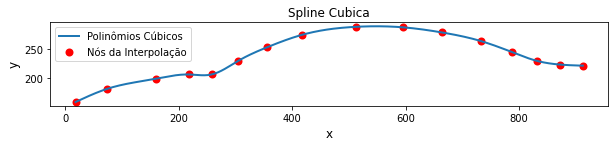

In [53]:
def natural_cubic_spline(P):   #funcao responsavel por calcular os coeficientes dos n-1 polinomios da spline cubica dado n nos de interpolacao
  n = len(P)
  A = np.zeros((n-2,n-2))
  b = np.zeros(n-2)
  h = np.zeros(n-1)
  w = np.zeros(n-1)
  u = np.zeros(n-1)

  for i in range(n-1):      #calculo dos h's
    h[i] = P[i+1][0] - P[i][0]   #hi = xi+1 - xi
    w[i] = (6.0/h[i])*(P[i+1][1] - P[i][1]) #wi = 6/hi*(yi+1 - yi)

  for i in range(1,n-1):      #preenchimento da diagonal principal de A e do vetor b
    u = 2*(h[i] + h[i-1])         #ui = 2*(hi + hi-1)
    A[i-1,i-1] = u                    #diagonal = ui
    b[i-1] = w[i] - w[i-1]        #vi = wi - wi-1

  for i in range(n-3):  #preenche a diagonal superior e inferior abaixo da principal da matriz tridiagonal A      
    A[i,i+1] = A[i+1,i] = h[i+1]  #diagonal acima e abaixo da principal = hi

  z = np.zeros(n)
  z[1:n-1] = np.linalg.solve(A,b) #resolvendo este sistema nos retorna os valores de z1 a zn-1   
  #zi = zn = 0, por isso natural

  S = np.zeros((n-1,4)) #onde sera armazenada nossa spline cubica natural, isto eh, os polinomios cubicos interpoladores que compoe a spline
      
  for i in range(n-1):
    S[i,0] = (z[i+1] - z[i])/(6*h[i]) #calculo do coeficiente ai = (zi+1 - zi)/6hi
    S[i,1] = z[i]/2.0                 #calculo do coeficiente bi = (zi/2)
    S[i,2] = - (h[i]*z[i+1]/6.0) - (h[i]*z[i]/3.0) + ((P[i+1][1]-P[i][1])/h[i]) #calculo do coeficiente ci
    S[i,3] = P[i][1]                  #calculo do coeficiente di

  return S



def evaluate_natural_cubic_spline(P,S,x):   #funcao responsavel por avaliar pontos na nossa spline cubica calculada
  n = np.shape(x)[0]
  y = np.zeros(n)

  j = 0
  i = 0
  while i < n:    #para todo ponto que queremos avaliar
    if x[i] <= P[j+1][0]:     #se esta no intervalo da spline correta (x < xi)
      y[i] = S[j,0]*pow(x[i] - P[j][0],3) + S[j,1]*pow(x[i]- P[j][0],2) + S[j,2]*(x[i]- P[j][0]) + S[j,3] #calculo do polinomio de terceiro grau
      i += 1
    else:   #se esta no intervalo de outra spline
      j += 1

  return y

#exemplo do contorno do carro do prof afonso paiva em seus slides sobre interpolacao polinomial
xi = []
yi = []
P  = []

xi = [18.5, 73.5, 160, 218, 258, 305, 356, 418, 513, 596, 664, 732, 787, 831, 871, 912]
yi = [157.5, 180.5, 198.5, 206, 206, 230, 254, 276, 290, 289, 280, 265, 245.5, 230, 223.5, 221.5]
#repare que no segundo ponto, alteramos de (73.5, 108.5) para (73.5, 180.5), pois apresentava um valor de y muito abaixo do primeiro ponto (18.5,157.5), o que nao condiz com a imagem. Na imagem, da para aferir que o segundo ponto tem coordenada y maior que o primeiro ponto!!! 
#acreditamos que seja um erro de digitacao nesta coordenada y do segundo ponto! 

P = list(zip(xi,yi))



x = np.linspace(18.5, 912, num=300, endpoint=True)  #pontos que queremos avaliar em nossa spline
S = natural_cubic_spline(P)
y = evaluate_natural_cubic_spline(P,S,x)  #avaliar estes pontos em nossa spline



plt.figure(figsize=(10,6),facecolor='white')
plt.scatter(xi,yi,label = 'Nós da Interpolação',linewidth = 2, c = 'red') #Plota os pontos que o polinomio interpolador deve passar
plt.plot(x,y,label = 'Polinômios Cúbicos',linewidth = 2) #Plota a spline cubica
plt.xlabel('x',fontsize='large') 
plt.ylabel('y',fontsize='large') 
plt.gca().set_aspect('equal', adjustable='box') #mantem a proporcao igual nos eixos para que tenhamos um desenho satisfatorio em escala 1:1
plt.title('Spline Cubica') 
plt.legend() 
plt.show()


###Spline Cúbica Natural X Interpolação de Lagrange
Agora vejamos para o mesmo exemplo acima, como se comporta a interpolação de lagrange. O resultado não acompanhou a função que desejávamos (contorno do carro), portanto podemos ver o quão superior é uma **interpolação por partes** que é adotada na **spline** e quão bem esta perfoma, acompanhando o contorno do carro suavemente entre as splines, por isto esta é escolhida para ser usada em contorno de objetos em programas como photoshop.

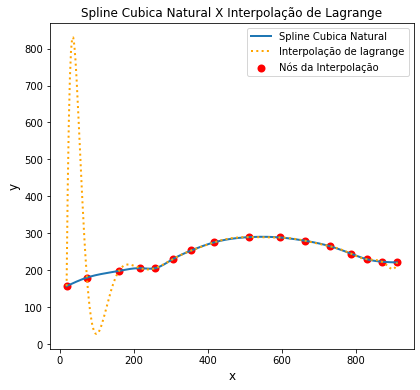

In [54]:
y_lagrange = lagrangePolynomialInterpolation(P,x)

plt.figure(figsize=(10,6),facecolor='white')
plt.scatter(xi,yi,label = 'Nós da Interpolação',linewidth = 2, c = 'red') #Plota os pontos que o polinomio interpolador deve passar
plt.plot(x,y,label = 'Spline Cubica Natural',linewidth = 2) #Plota a spline cubica
plt.plot(x,y_lagrange,label = 'Interpolação de lagrange', linewidth = 2, c = 'orange', linestyle= 'dotted')
plt.xlabel('x',fontsize='large') 
plt.ylabel('y',fontsize='large') 
plt.gca().set_aspect('equal', adjustable='box') #mantem a proporcao igual nos eixos para que tenhamos um desenho satisfatorio em escala 1:1
plt.title('Spline Cubica Natural X Interpolação de Lagrange') 
plt.legend() 
plt.show()

##Spline Natural x Fixada

Apenas para fins teóricos, vamos comentar sobre spline natural e fixada.

A spline natural contem todas as equações e restrições citadas anteriormente, com adição de duas equações adicionais:

$S''(x_{1}) = S''(x_{n}) = 0$.

Ou seja, estamos definindo condições de que no inicio e fim do intervalo, a derivada segunda deve ser igual a zero.

A spline natural possui solução única, pois a matriz formada possui diagonal dominante.

A spline fixada também contém todas as equações e restrições, com diferença que escolhemos os valores nas extremidades do intervalo de interpolação.
Isso diminui o número de variaveis para $n-2$ pois $y'_{1}$ e $y'_{n}$ deixam de ser incógnitas.

Como a matriz formada diagonal dominante estrita, possui solução única.

#**[TÓPICO 4]: Método dos mínimos quadrados**
---
Muitas vezes nos deparamos com funções muito complexas, com cálculo complicado de suas derivadas ou integrais. 

Para manipular uma função difícil, podemos aproximá-la para uma função mais simples, e então realizar o cálculos por meio da função mais simples encontrada. Com o método dos minímos quadrados, conseguimos aproximar uma função qualquer por uma combinação de funções conhecidas, sendo que a aproximação conhecida é a melhor possível

Outra aplicação para o método dos mínimos quadrados é encontrar uma função que não conhecemos por meio de pontos dados (discretamente), isto é, encontrando uma relação funcional entre estes pontos. Neste método não é necessário que a função obtida passe pelos os pontos passados, diferente do método de interpolação que o polinômio interpolador encontrado deveria passar por todos os nós de interpolação. 



Porém antes de avançarmos, devemos relembrar alguns conceitos usados de álgebra linear, tais como:

*   A norma $||.||_{2}$ de uma função $f \in C([a, b])$ é dado pelo produto interno: $<f,f>$

*   Dois vetores $u,v$ de um mesmo espaço vetorial qualquer são ortogonais $\leftrightarrow$ $<u,v> = 0$

*   Dados dois vetores $u,v$ de um mesmo espaço vetorial qualquer, temos que o vetor projeção ortogonal de $u$ na direção de $v$ é $proj_{v}(u) = \frac{<u,v>}{<v,v>}v$

A partir disso temos um teorema importante para nossos cálculos no método de mínimos quadrados. Dado um espaço vetorial $U$ e um subespaço de dimensão finita de $V$ contido em $U$ e um vetor $u \in U$, a projeção ortogonal de $u$ no subespaço $V$ isto é $v* \in V$ é a melhor aproximação de $u$ no subespaço $V$, tal que para qualquer $v \in V$ diferente de $v*$ temos que $||u-v*||_{2} < ||u-v||_{2}$. Desta forma, dado que $v*$ pode ser escrito como combinação linear: $v* = \alpha_{0}\phi_{0} + \alpha_{1}\phi_{1} + ... + \alpha_{n} \phi_{n}$ em que $\beta = \{\phi_{0}, \phi_{1}, \phi_{2}, ..., \phi_{n}\}$ é uma base do subespaço $V$ e encontramos os alphas como resolução do sistema $A\alpha = b$, em que A é uma matriz simétrica:

$A = \begin{pmatrix}
\langle \phi_{0}, \phi_{0} \rangle & \langle \phi_{0}, \phi_{1} \rangle & \ldots &  \langle \phi_{0}, \phi_{n} \rangle\\
\langle \phi_{1}, \phi_{0} \rangle & \langle \phi_{1}, \phi_{1} \rangle & \ldots &  \langle \phi_{1}, \phi_{n} \rangle\\
\vdots & \vdots & \ddots & \vdots\\
\langle \phi_{n}, \phi_{0} \rangle &  \langle \phi_{n}, \phi_{1} \rangle &  \ldots & \langle \phi_{n}, \phi_{n} \rangle
\end{pmatrix}$

$\alpha = \begin{pmatrix}
\alpha_0\\
\alpha_1\\
\vdots\\
\alpha_n
\end{pmatrix}$

$b = \begin{pmatrix}
\langle \phi_{0}, u \rangle\\
\langle  \phi_{1}, u \rangle\\
\vdots\\
\langle  \phi_{n}, u \rangle
\end{pmatrix}$

E este possui solução única!

## Caso contínuo

Dada uma função $f \in C([a, b])$, desejamos aproximar $f(x)$ por um polinômio pertencente a $P_m$ que é subespaço vetorial de $C([a, b])$, ou seja, utilizando do teorema acima:

* $f(x) \approx \alpha_0 + \alpha_1x + ... + \alpha_mx^m = P_m(x)$

Sabemos que $\beta = \{1, x, x^2, ..., x^n\}$ é uma base de $P_m(x)$, para obter o polinômio devemos resolver o sistema abaixo:

$A = \begin{pmatrix}
\langle 1, 1 \rangle & \langle 1, x \rangle & \ldots &  \langle 1, x^m \rangle\\
\langle x, 1 \rangle & \langle x, x \rangle & \ldots &  \langle x, x^m \rangle\\
\vdots & \vdots & \ddots & \vdots\\
\langle x^m, 1 \rangle &  \langle x^m, x \rangle &  \ldots & \langle x^m, x^m \rangle
\end{pmatrix}$


$\alpha = \begin{pmatrix}
\alpha_0\\
\alpha_1\\
\vdots\\
\alpha_m
\end{pmatrix}$


$b = \begin{pmatrix}
\langle 1, f \rangle\\
\langle x, f \rangle\\
\vdots\\
\langle x^m, f \rangle
\end{pmatrix}$


Onde $A\alpha = b$

No caso contínuo, devemos considerar o produto interno como:

* $\langle f, g \rangle = \int_a^b\, f(x)g(x)dx$, onde $[a,b]$ é o intervalo em que a função $f$ está definida.

Resolvendo o sistema linear, que tem solução única, encontramos o polinômio $P_m(x)$ que melhor aproxima a função.


Polinômio Encontrado: 
[1.01299131 0.85112505 0.83918398]


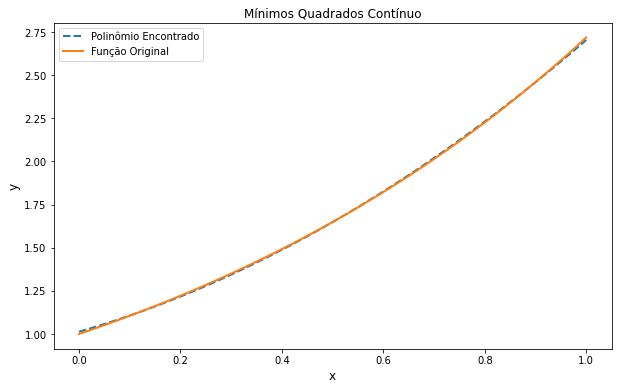

In [55]:
import numpy as np
import math
from scipy.integrate import quad
import matplotlib.pyplot as plt



def function_multiply(x,f,n): #funcao responsavel por multiplicar a funcao que queremos aproximar f(x) com x^n, usado para calcular <x^n,f> nos minimos quadrados
  return f(x)*pow(x,n)

def minimos_quadrados_continuo(f,I,m):  #funcao responsavel por aproximar uma funcao f(x) a um polinomio de grau m no intervalo I utilizando o metodo dos minimos quadrados continuo 
  A = np.zeros((m+1,m+1))
  b = np.zeros(m+1)

  for j in range(m+1): #para cada coluna da nossa matriz A
    n = j 
    aux = quad(function_multiply, I[0], I[1], args=(f,n)) #calcula o produto escalar <x^n,f> por meio da integral dado o intervalo I de f(x).x^n
    b[j] = aux[0]   #preenche b[j] com a integral calculada acima
    for i in range(j,m+1):      #calcula apenas para os elementos da diagonal para baixo, uma vez que eh uma matriz simetrica
      n = i + j
      aux = quad(pow, I[0], I[1], args=(n))  #calcula <x^i,x^j> isto eh, a integral dado o intervalo I de x^(i).x^(j) = x^(i+j)
      A[i,j] = aux[0]       #preenche A[i,j] com a integral calculada acima
  
  A_t = np.copy(A)
  A_t = np.transpose(A_t)
  np.fill_diagonal(A_t,0)
  A = A + A_t     #como calculamos metade de A apenas, somamos com sua transposta sem diagonal e obtemos uma matriz simetrica


  polynomial = np.linalg.solve(A,b) #resolvendo o sistema linear obtemos os coeficientes do polinomio de grau m encontrado que melhor aproxima a funcao

  return polynomial




f = lambda x: math.exp(x)   #define como lambda a funcao que queremos encontrar um polinomio que aproxime desta

P = minimos_quadrados_continuo(f,(0,1),2) #queremos encontrar um polinomio de grau 2 que melhor se aproxima da funcao exponencial no intervalo de 0 a 1

print('Polinômio Encontrado: ') 
print(P) #imprime os coeficientes do polinomio encontrado que melhor aproxima a funcao 

x = np.linspace(0, 1, num=50, endpoint=True) #nos retorna 50 coordenadas em x entre 0 e 1 uniformemente espacados 
y = PolynomialEvaluate(P,x) #a partir destas coordenadas em x, vamos avaliar no nosso polinomio achado
y_func = evaluate_function(x,f)  #a partir destas coordenas em x, vamos avaliar na nossa funcao original

#Plot do grafico
plt.figure(figsize=(10,6),facecolor='white')
plt.plot(x,y,label = 'Polinômio Encontrado',linestyle ='dashed', linewidth = 2)
plt.plot(x,y_func,label = 'Função Original',linewidth = 2)  
plt.xlabel('x',fontsize='large') 
plt.ylabel('y',fontsize='large') 
plt.title('Mínimos Quadrados Contínuo') 
plt.legend() 
plt.show()

## Caso discreto

No caso discreto, não teremos uma função definida para aproximar.Nós conhecemos apenas determinada quantidade de pontos no espaço e devemos aproximar por um polinômio $P_m(x)$. Assim como na interpolação polinomial, são conhecidos vários pontos e queremos aproximar, porém no método dos mínimos quadrados não é necessário que o polinômio aproximador passe pelos pontos.

Sendo assim, dada uma função $f(x)$ amostrada, ou seja, é conhecida apenas $(n+1)$ pares de pontos:

* $(x_0, y_0), (x_1, y_1), ..., (x_n, y_n)$

onde $y_i = f(x_i), i = 0, ..., n$, com os $(n+1)$ pontos $x_0, x_1, ..., x_N$ distintos.

O objetivo é aproximar a função $f$ por um polinômio $P_m$, tal que:

  * $f(x) \approx \alpha_0 + \alpha_1x + ... + \alpha_mx^m = P_m(x)$, com $m < n$.

Para achar todos os valores de $\alpha$, basta resolver o sistema de equações:

$A = \begin{pmatrix}
\langle u_0, u_0 \rangle & \langle u_0, u_1 \rangle & \ldots &  \langle u_0, u_m \rangle\\
\langle u_1, u_0 \rangle & \langle u_1, u_1 \rangle & \ldots &  \langle u_1, u_m \rangle\\
\vdots & \vdots & \ddots & \vdots\\
\langle u_m, u_0 \rangle &  \langle u_m, u_1 \rangle &  \ldots & \langle u_m, u_m \rangle
\end{pmatrix}$


$\alpha = \begin{pmatrix}
\alpha_0\\
\alpha_1\\
\vdots\\
\alpha_m
\end{pmatrix}$


$b = \begin{pmatrix}
\langle u_0,y \rangle\\
\langle u_1,y \rangle\\
\vdots\\
\langle u_m, y \rangle
\end{pmatrix}$


Onde $A\alpha = b$ e $U = \{u_0 = (x_0^0, x_1^0, ..., x_ n^0), u_1 = (x_0^1, x_1^1, ..., x_ n^1), ..., u_m = (x_0^m, x_1^m, ..., x_ n^m)\}$ e temos que $y=(y_0,y_1,...,y_n)$

No caso discreto, devemos considerar o produto interno como:

*  $\langle v, w \rangle = \sum_{k=0}^{n} v_iw_i$

Polinômio Encontrado: 
[-1.6  0.2  2. ]


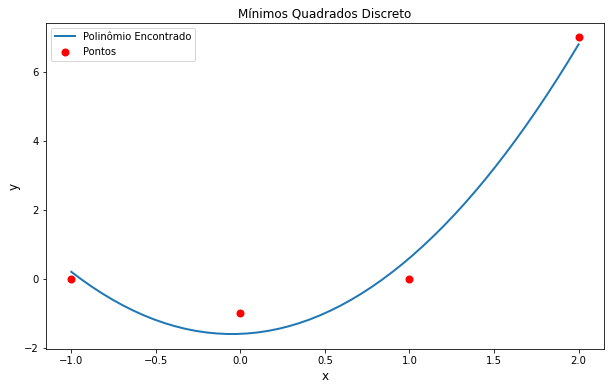

In [56]:
def minimos_quadrados_discreto(P,m):  #Dado um conjunto de pontos P acha o polinomio de grau m que mais se aproxima destes
  A = np.zeros((m+1,m+1))
  b = np.zeros(m+1)
  
  n = len(P)
  y = np.zeros(n)
  u = np.zeros(n)

  for i in range(n):  #inicializa nossos vetores u e y auxiliares
    u[i] = P[i][0]
    y[i] = P[i][1]


  for j in range(m+1): #para cada coluna da nossa matriz A
    u_c = np.power(u,j)   #realiza u^j
    b[j] = u_c.dot(y)     #reliza o produto interno <u^j, y> e armazena em nosso vetor b
    for i in range(j,m+1):      #calcula apenas para os elementos da diagonal para baixo, uma vez que eh uma matriz simetrica      
      A[i,j] = np.power(u,i).dot(u_c) #realiza o produto interno <u^i,u^j> e armazena em nossa matriz A
  

  A_t = np.copy(A)
  A_t = np.transpose(A_t)
  np.fill_diagonal(A_t,0)
  A = A + A_t     #como calculamos metade de A apenas, somamos com sua transposta sem diagonal e obtemos uma matriz simetrica


  polynomial = np.linalg.solve(A,b) #resolvendo o sistema linear obtemos os coeficientes do polinomio de grau m encontrado que melhor aproxima dos pontos passados
  return polynomial
  


P = []
xi = []
yi = []

xi.append(-1)
yi.append(0)
P.append((-1,0))
xi.append(0)
yi.append(-1)
P.append((0, -1))
xi.append(1)
yi.append(0)
P.append((1, 0))
xi.append(2)
yi.append(7)
P.append((2, 7))

P = minimos_quadrados_discreto(P,2)  #encontra o polinomio de grau 2 que melhor se aproxima dos pontos passados

print('Polinômio Encontrado: ') 
print(P) #imprime os coeficientes do polinomio encontrado que melhor aproxima dos pontos passados 

x = np.linspace(-1, 2, num=50, endpoint=True) #nos retorna 50 coordenadas em x entre -1 e 2 uniformemente espacados 
y = PolynomialEvaluate(P,x) #a partir destas coordenadas em x, vamos avaliar no nosso polinomio achado

#Plot do grafico
plt.figure(figsize=(10,6),facecolor='white')
plt.plot(x,y,label = 'Polinômio Encontrado', linewidth = 2)
plt.scatter(xi,yi, label= 'Pontos', c = 'red', linewidth = 2)
plt.xlabel('x',fontsize='large') 
plt.ylabel('y',fontsize='large') 
plt.title('Mínimos Quadrados Discreto') 
plt.legend() 
plt.show()

###**APLICAÇÃO: Aproximação de uma função sobre os casos totais de coronavírus**

Esta aplicação consiste em dado um conjunto de pontos $(\textrm{dia}_0,\textrm{total de casos}_0),...,(\textrm{dia}_n,\textrm{total de casos}_n)$ encontrar uma função que melhor aproxima dos pontos passados, usando o método dos mínimos quadrados do tipo discreto, uma vez que só é dado um conjunto de pontos de uma função desconhecida. Porém, queremos aproximar uma função não-linear, uma vez que esta possui melhor aproximação real do conjunto de pontos. A função não-linear escolhida é a $f(x) = ab^x$, porém nossa função de minímos quadrados aproxima apenas de um polinômio, então podemos aplicar $ln()$ na função e obtemos:
$$ln(f(x)) = ln(ab^x) = ln(a) + ln(b)x$$
Que pode ser reescrita como:
$$ln(f(x)) = A + Bx$$
Desta forma podemos utilizar nosso método dos minímos quadrados do tipo discreto aproximando o conjunto de pontos passados por um polinômio do primeiro grau. Logo, nosso conjunto de pontos passados para o método dos mínimos quadrados passa a ser $$(\textrm{dia}_0,ln(\textrm{total de casos}_0)),...,(\textrm{dia}_n,ln(\textrm{total de casos}_n))$$
Como resultado, o método dos mínimos quadrados nos retornará os coeficientes de um polinômio de grau 1, isto é, $A$ e $B$, porém como temos que $A = ln(a)$ e $B = ln(b)$, para obtermos os coeficientes de nossa função não-linear precisamos aplicar a função inversa, logo: $a = exp(A)$ e $b = exp(B)$ e então obtemos a função não-linear que melhor se aproxima.

Entretanto, veremos que graças à medidas de combate ao vírus como lockdowns e quarentena a curva teve seu crescimento desacelerado se comparado ao início e portanto, devemos estudar diversas curvas partindo de dias diferentes da epidemia. Exemplificando: uma curva a partir do $\textrm{dia}_0$ terá resultados bem mais desastrosos do que a realidade, pois teria o crescimento acelerado do início, porém se pegarmos uma curva a partir do início da adoção de políticas de combate ao coronavírus, teremos uma curva mais suave e mais condizente com a realidade, isto é, menos acelerada.

Em nossa aplicação, trabalhamos com os dados atualizados cedidos pelo estado de São Paulo e pela OMS para compararmos os países do mundo todo, isto é, sempre que executarmos novamente, teremos os dados mais atualizados possível baixados em tempo real do site do governo do estado de São Paulo e da OMS.


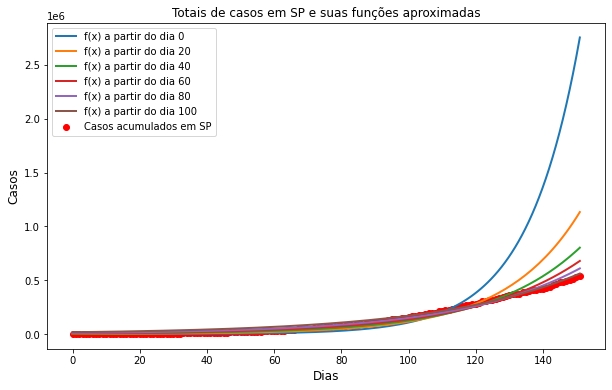

In [57]:
import csv
import requests

link = 'http://www.seade.gov.br/wp-content/uploads/2020/07/Dados-covid-19-estado.csv'   #baixa o arquivo .csv dos dados do estado de sao paulo que sao atualizados diariamente, entao sempre que executar, tera os dados mais recentes publicados
req = requests.get(link)    #faz uma requisicao do conteudo ao site
content = req.content       
csv_writer = open('/content/sp.csv', 'wb') #abre um arquivo novo

csv_writer.write(content) #salva o conteudo que foi baixado do site e armazena neste arquivo aberto
csv_writer.close()        #fecha a conexao


i = 0   #numero de dias

with open('/content/sp.csv','r',encoding='latin-1') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter = ';')   #usa da biblioteca csv para parsear os dados do arquivo .csv do coronavirus do estado de SP

  next(csv_reader)    #pula a primeira linha que contem os metadados apenas
  P = []
  xi = []
  yi = []

  for line in csv_reader:   #para cada linha no nosso arquivo .csv
    if line[1] == '' and line[2] == '':   #se chegamos no final em que so ha dados nulos
      break
    
    
    if line[1] != '' and int(line[1]) != 0: #se nao eh nulo e nem zero casos
      y_log = math.log(float(line[1]))    #aplica log sobre a coordenada y do ponto como comentado na teoria acima
      yi.append(int(line[1]))
      P.append((i,y_log))           #ao inves de termos (dia_i,yi) temos (dia_i, ln(yi)) para aproximar da funcao nao linear ab^x posteriormente
      xi.append(i)
      i+=1


  csv_file.close()
f = lambda a,b,x: a*pow(b,x)      #nossa funcao nao linear f(x) = ab^x


plt.figure(figsize=(10,6),facecolor='white')

begin = 0   #a partir de qual dia queremos que nossa primeira curva comecara
for j in range(6):  #plotaremos 6 curvas com inicios distintos
  Poly = minimos_quadrados_discreto(P[begin:],1)    #aplica o metodo dos minimos quadrados no conjunto de pontos passados a partir do ponto do dia begin

  a = math.exp(Poly[0])     #obtem os coeficientes a e b de nossa funcao nao linear
  b = math.exp(Poly[1])

  x = np.linspace(0, i-1, num=150, endpoint=True)  #nos retorna 150 coordenadas em x entre 0 e i-1 uniformemente espacadas


  plt.plot(x,f(a,b,x),label = 'f(x) a partir do dia %d' %(begin), linewidth = 2)  #plotamos a curva obtida aproximacao da funcao nao linear a partir do dia begin

  begin += 20 #dia que comecara a proxima curva

#plotagem dos pontos e do grafico
plt.scatter(xi,yi, label= 'Casos acumulados em SP', c = 'red', linewidth = 1)
plt.xlabel('Dias',fontsize='large')  
plt.ylabel('Casos',fontsize='large') 
plt.title('Totais de casos em SP e suas funções aproximadas') 
plt.legend() 
plt.show()

A próxima parte da implementação consiste em uma função capaz de comparar os casos acumulados de coronavírus de quaisquer 2 países do mundo pelos dados que são fornecidos pela OMS e atualizados diariamente, então sempre que executarmos, obtemos a última versão disponível do .csv cedido pela OMS a respeito da situação do coronavírus em todos os países do mundo. A função de comparação possui os seguintes parâmetros:

*   **country1** - String nome em inglês do primeiro país que desejamos comparar, é necessário olhar o .csv da OMS para ver como a OMS escreve o nome do país no arquivo!!
*   **country2** - String nome em inglês do segundo país que desejamos comparar
*   **n_curves1** - Quantidade de curvas não-lineares de início em dias diferentes que melhor aproximam a situação do país a partir daquele dia que desejamos comparar do primeiro país
*   **n_curves2**  - Quantidade de curvas não-lineares de início em dias diferentes que melhor aproximam a situação do país a partir daquele dia que desejamos comparar do segundo país 
*   **step1** - passo de dias entre cada curva do primeiro país a ser comparada começando de **start1**
*   **step2** - passo de dias entre cada curva do segundo país a ser comparada começando de **start2**  
*   **start1** - a partir de qual dia a primeira curva não-linear do primeiro país tem início
*   **start2** - a partir de qual dia a primeira curva não-linear do segundo país tem início

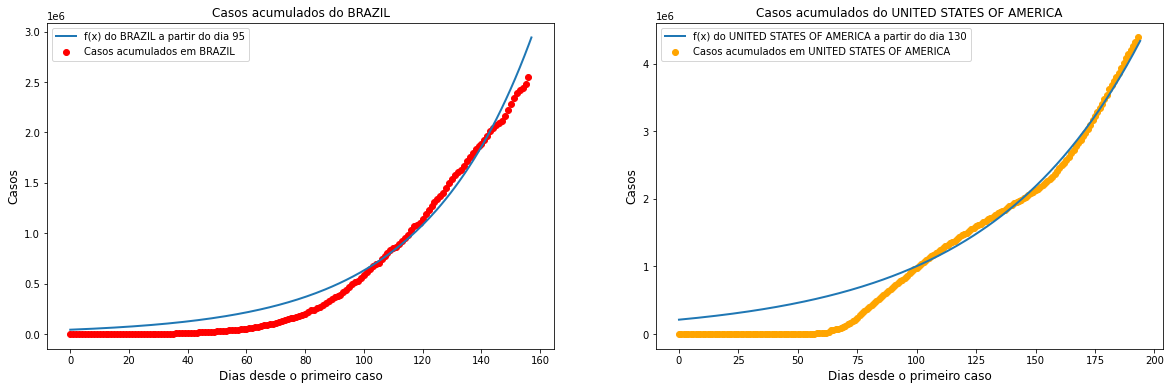

In [58]:
def compareCountriesCases(country1, country2, n_curves1, n_curves2, step1, step2, start1, start2):
  country1 = country1.upper()
  country2 = country2.upper()
  
  link = 'https://covid19.who.int/WHO-COVID-19-global-data.csv'   

  req = requests.get(link)    #faz uma requisicao do conteudo ao site da OMS
  content = req.content       
  csv_writer = open('/content/paises.csv', 'wb') #abre um arquivo novo

  csv_writer.write(content) #salva o conteudo que foi baixado do site e armazena neste arquivo aberto
  csv_writer.close()        #fecha a conexao

  with open('/content/paises.csv','r', encoding='latin-1') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')   #usa da biblioteca csv para parsear os dados do arquivo .csv do coronavirus do mundo inteiro cedido pela OMS

    next(csv_reader)    #pula a primeira linha que contem os metadados apenas
  
    P1 = []       #Conjunto de pontos de casos acumulados diarios do pais 1
    xi1 = []
    yi1 = []

    P2 = []       #Conjunto de pontos de casos acumulados diarios do pais 2
    xi2 = []
    yi2 = []

    i1 = 0    #armazenara o numero de dias desde o primeiro caso no pais 1 no arquivo da OMS
    i2 = 0    #armazenara o numero de dias desde o primeiro caso no pais 2 no arquivo da OMS
    for line in csv_reader:   #para cada linha no nosso arquivo .csv
      if line[2].upper() == country1 and int(line[5]) != 0: #se nao eh nulo e nem zero casos e o nome coincide com o pais 1 que desejamos comparar
        y_log = math.log(float(line[5]))    #aplica log sobre a coordenada y do ponto
        yi1.append(int(line[5]))
        P1.append((i1,y_log))           #ao inves de termos (dia_i,yi) temos (dia_i, ln(yi)) para aproximar da funcao nao linear ab^x posteriormente
        xi1.append(i1)
        i1+=1

      elif line[2].upper() == country2 and int(line[5]) != 0: #se nao eh nulo e nem zero casos e o nome coincide com o pais 2 que desejamos comparar
        y_log = math.log(float(line[5]))    #aplica log sobre a coordenada y do ponto
        yi2.append(int(line[5]))
        P2.append((i2,y_log))           #ao inves de termos (dia_i,yi) temos (dia_i, ln(yi)) para aproximar da funcao nao linear ab^x posteriormente
        xi2.append(i2)
        i2+=1



    painel = plt.figure(1, figsize=(20,6), facecolor='white') #criamos um painel para disponibilizar os graficos do pais 1 e pais 2 lado a lado
    ax1 = painel.add_subplot(1,2,1)

    #CALCULO DAS CURVAS DO PAIS 1
    begin = start1
    for i in range(n_curves1):  #para cada curva nao-linear que desejamos encontrar do pais 1
       Poly = minimos_quadrados_discreto(P1[begin:],1)    #aplica o metodo dos minimos quadrados no conjunto de pontos passados a partir do ponto do dia begin

       a = math.exp(Poly[0])     #obtem os coeficientes a e b de nossa funcao nao linear
       b = math.exp(Poly[1])

       x = np.linspace(0, i1, num=200, endpoint=True)  #nos retorna 200 coordenadas em x entre 0 e i1 uniformemente especadas


       plt.plot(x,f(a,b,x),label = 'f(x) do %s a partir do dia %d' %(country1,begin), linewidth = 2)  #plotamos a curva obtida aproximacao da funcao nao linear a partir do dia begin

       begin += step1 #dia que comecara a proxima curva
       #isto eh teremos n_curves1 com inicios em (start1, start1+step1, start1 + 2*step1, start1 + 3*step1, ..., start1 + (n_curves1-1)*step1)

    plt.scatter(xi1,yi1, label= 'Casos acumulados em %s' %(country1), c = 'red', linewidth = 1)
    plt.xlabel('Dias desde o primeiro caso',fontsize='large')  
    plt.ylabel('Casos',fontsize='large') 
    ax1.title.set_text('Casos acumulados do %s' %(country1))
    plt.legend()

    ax2 = painel.add_subplot(1,2,2)

    #CALCULO DAS CURVAS DO PAIS 2
    begin = start2
    for i in range(n_curves2):   #para cada curva nao-linear que desejamos encontrar do pais 2
       Poly = minimos_quadrados_discreto(P2[begin:],1)    #aplica o metodo dos minimos quadrados no conjunto de pontos passados a partir do ponto do dia begin

       a = math.exp(Poly[0])     #obtem os coeficientes a e b de nossa funcao nao linear
       b = math.exp(Poly[1])

       x = np.linspace(0, i2, num=200, endpoint=True)  #nos retorna 200 coordenadas em x entre 0 e i2 uniformemente especadas


       plt.plot(x,f(a,b,x),label = 'f(x) do %s a partir do dia %d' %(country2,begin), linewidth = 2)  #plotamos a curva obtida aproximacao da funcao nao linear a partir do dia begin

       begin += step2 #dia que comecara a proxima curva
       #isto eh teremos n_curves2 com inicios em (start2, start2+step2, start2 + 2*step2, start2 + 3*step2, ..., start2 + (n_curves2-1)*step2)

    plt.scatter(xi2,yi2, label= 'Casos acumulados em %s' %(country2), c = 'orange', linewidth = 1)
    plt.xlabel('Dias desde o primeiro caso',fontsize='large')  
    plt.ylabel('Casos',fontsize='large') 
    ax2.title.set_text('Casos acumulados do %s' %(country2))
    plt.legend()
    
    plt.show()

compareCountriesCases('Brazil','United States of America',1,1,0,0,95,130) 
# Vamos ver um exemplo de comparacao entre Brasil e Estados Unidos
# Para cada pais plotamos apenas uma curva nao-linear
# Para o Brasil, esta curva tem inicio no dia 95 desde o primeiro caso
# Para o Estados Unidos, esta curva tem inicio no dia 130 desde o primeiro caso

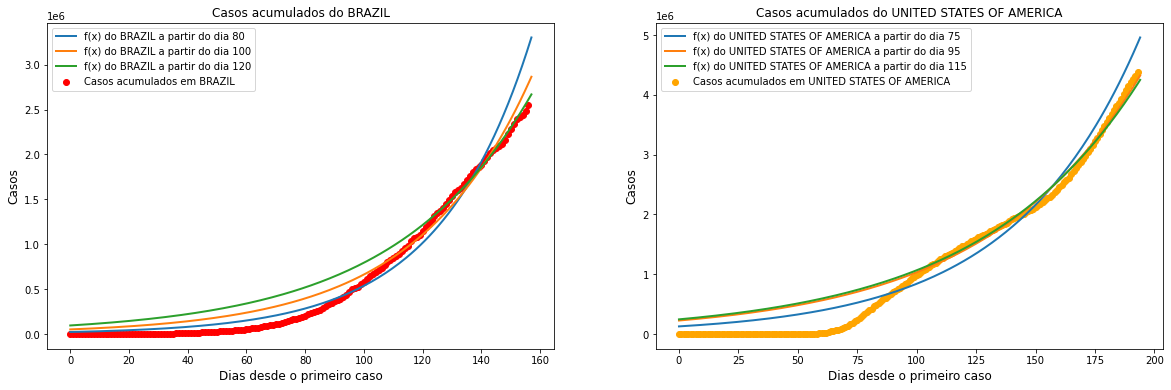

In [59]:
compareCountriesCases('Brazil','United States of America',3,3,20,20,80,75) 
#Mais um exemplo de comparacao entre Brasil e Estados Unidos
#Para cada pais plotamos 3 curvas nao-lineares de 20 dias de diferenca entre o inicio de cada
#Para o Brasil, a primeira curva tem inicio no dia 80 desde o primeiro caso
#Para o Estados Unidos, a primeira curva tem inicio no dia 75 desde o primeiro caso

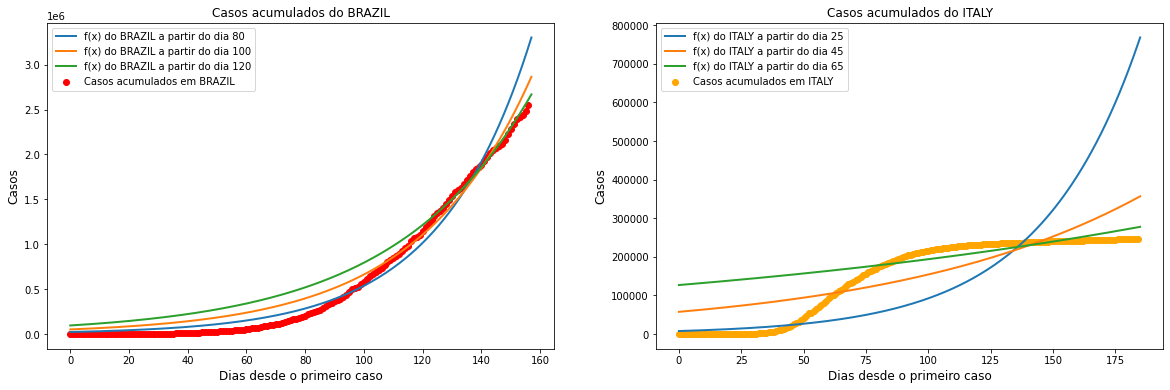

In [60]:
compareCountriesCases('Brazil','Italy',3,3,20,20,80,25)
#Um exemplo de comparacao entre as curvas do Brasil e da Italia
#Para cada pais plotamos 3 curvas nao-lineares de 20 dias de diferenca entre o inicio de cada
#Para o Brasil, a primeira curva tem inicio no dia 80 desde o primeiro caso
#Para a Italia, a primeira curva tem inicio no dia 25 desde o primeiro caso

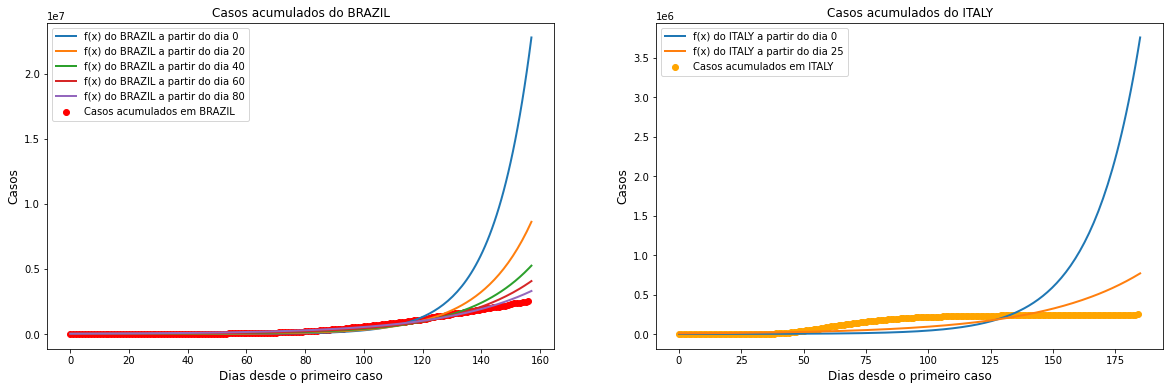

In [61]:
compareCountriesCases('Brazil','Italy',5,2,20,25,0,0)
#Outro exemplo de comparacao entre as curvas do Brasil e da Italia
#Para o Brasil plotamos 5 curvas com diferenca de 20 dias entre o inicio de cada e a partir do dia 0
#Para a Italia plotamos 2 curvas com diferenca de 25 dias entre o inicio de cada e a partir do dia 0

#Podemos ver que a Italia inicialmente teria um cenario mais desastroso do que no Brasil, antes que as medidas de quarentena fossem aplicadas!

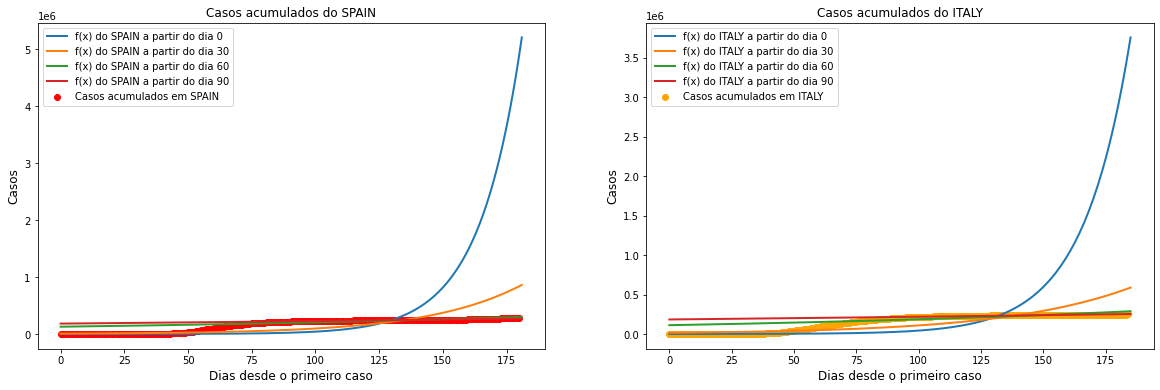

In [62]:
compareCountriesCases('Spain','Italy',4,4,30,30,0,0)
#Em outro exemplo temos uma comparacao entre espanha e italia
#Plotamos para cada 4 curvas de 30 dias diferenca entre o inicio de cada a partir do dia 0

Estes foram só alguns exemplos do que é possível fazer com essa função de comparação, porém podemos fazer para todos os países que a OMS possui em seus dados, com quantas curvas quiseremos, com tantos dias desde o primeiro caso e com tantos dias entre cada curva.